In [45]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from support_code.model import DQN
from support_code.env import TradingEnv
from support_code.functions import fetch_data, buy_and_hold, pickle_model, corr

In [46]:
import warnings
warnings.simplefilter('ignore')

---
---
---
### Random back testing

In [47]:
df = fetch_data('sp500_df')

starting_balance = 1_000_000

env = TradingEnv(df, balance_init=starting_balance)
env.verbose=1

In [48]:
np.random.seed(None)
env.seed(None)

In [49]:
done = False
obs = env.reset()
start = env.current_step

stock_performance = []
model_performance = []
actions = []

while not done:
    
    stock_performance.append(df.loc[env.current_step]['close'])
    model_performance.append(env.net_worth)
        
    action = np.random.randint(env.action_space.n)
    obs, rewards, done, info = env.step(action)

    actions.append(env._actions[action])
    
end = env.current_step

current price 1198.75
action 0.25
total possible to buy 833.3689251311777
number bought 208.34223128279442
cost of buying 250000.00000000003
balance 750000.0 shares held 208.34223128279442
previous net worth 1000000 current net worth 999750.2497502498

current price 1197.75
action -0.75
total possible to sell 208.34223128279442
number sold 156.25667346209582
profit from selling 186969.27420858602
balance 936969.274208586 shares held 52.0855578206986
previous net worth 999750.2497502498 current net worth 999354.7510883277

current price 1111.25
action 0.5
total possible to buy 842.32462629257
number bought 421.162313146285
cost of buying 468484.637104293
balance 468484.637104293 shares held 473.24787096698356
previous net worth 999354.7510883277 current net worth 994381.3337163534

current price 1171.75
action -0.75
total possible to sell 473.24787096698356
number sold 354.93590322523767
profit from selling 415480.248459568
balance 883964.885563861 shares held 118.31196774174589
previou

---

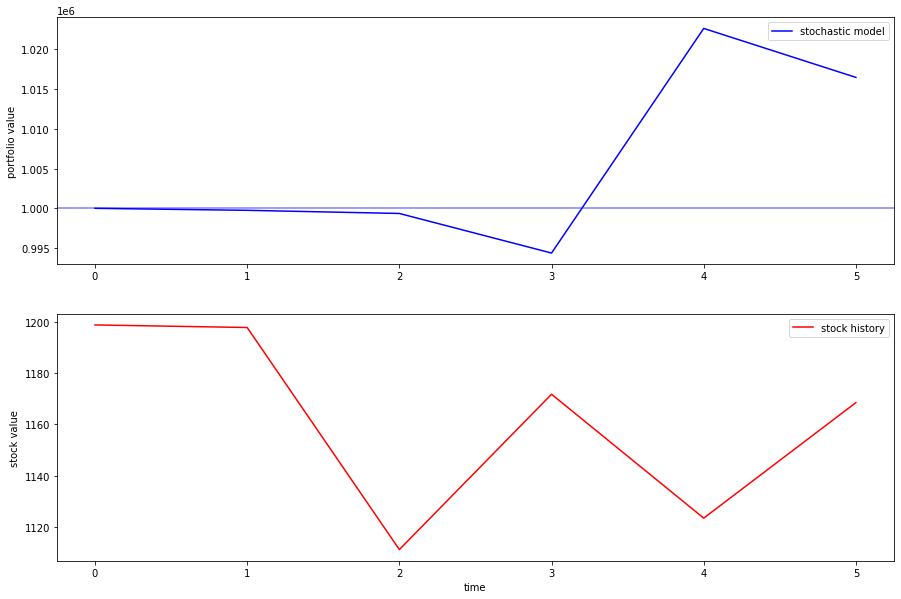

In [50]:
fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

ax1.plot(model_performance, 'b-', label='stochastic model')
ax1.set_ylabel('portfolio value')
ax1.axhline(starting_balance, alpha=0.5, color='blue')
ax1.legend()

ax2.plot(stock_performance, 'r-', label='stock history')
ax2.set_ylabel('stock value')
ax2.set_xlabel('time')
ax2.legend()

plt.show();

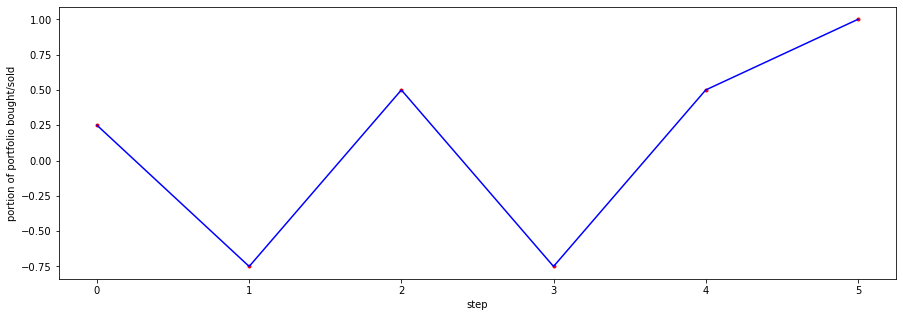

In [51]:
plt.figure(figsize=(15,5))
plt.plot(actions, 'r.')
plt.plot(actions, 'b-')
plt.xlabel('step')
plt.ylabel('portion of portfolio bought/sold')

plt.show();

In [9]:
corr(actions, stock_performance)

0.0675139652096318

---
---
---
### Training/backtesting

In [53]:
df = fetch_data('sp500_df')
#df.shape

In [54]:
np.random.seed(None)

starting_balance = 1_000_000

env = TradingEnv(df, balance_init=starting_balance)
env.verbose=0
env.seed(None)

#print(env.action_space, env.observation_space)

In [55]:
dqn_solver = DQN(
    action_space=env.action_space.n, 
    state_space=env.observation_space.shape,
    batch_size=64,
    memory_size=1_000_000,
    alpha=1.0,
    alpha_decay=0.999,
    alpha_min=0.1,
    gamma=0.99,
    )

dqn_solver.verbose = 0
#dqn_solver.model.summary()

In [56]:
history = []

In [64]:
for i in np.arange(750, 2500):
    
    # Reset the evironment at the top of each episode
    state = env.reset()
    
    stock_performance = []
    model_performance = []
    reward_trace = []    
    actions = []
    
    start = env.current_step
    done = False    
    
    # The model will iterate until a terminal state is reached
    while not done:
                
        # Select an action by passing the current observation/state to the DQN
        action = dqn_solver.act(state)
        
        # The environment takes a step according to that action and returns the new state, the reward, and the terminal status
        next_state, reward, done, info = env.step(action)
                
        # Commit to the DQN's memory the relevant information
        dqn_solver.remember(state, action, reward, next_state, done)
        
        # Update the current state
        state = next_state

        actions.append(action)
        reward_trace.append(reward)
        model_performance.append(env.net_worth)  
        stock_performance.append(df.loc[env.current_step]['close'])
            
    print('================================================================================================================')
    print(i+1)
    print('FINAL PROFIT', env.net_worth-env.balance_init)
    print('TOTAL REWARD:', np.mean(reward_trace))
    print('DAY RANGE:', start, env.current_step)
    print('EXPLORATION:', dqn_solver.alpha)
    print('MEMORY SIZE:', len(dqn_solver.memory))
    print('================================================================================================================')
    
    # After each episode, perform experience replay
    test = dqn_solver.replay()  
    
    print('\n\n\n')
    
    history.append({
        'stock': stock_performance,
        'model': model_performance,
        'actions': actions,
        'rewards': np.mean(reward_trace),
        })

X, y = test

751
FINAL PROFIT 4859.532443298143
TOTAL REWARD: 0.0006430515374527615
DAY RANGE: 1886 1909
EXPLORATION: 0.4731351274767304
MEMORY SIZE: 27157




752
FINAL PROFIT 6407.544935412123
TOTAL REWARD: -0.0026436516008463556
DAY RANGE: 1571 1578
EXPLORATION: 0.4726619923492537
MEMORY SIZE: 27164




753
FINAL PROFIT -999.0009990008548
TOTAL REWARD: 0.0
DAY RANGE: 2102 2103
EXPLORATION: 0.47218933035690447
MEMORY SIZE: 27165




754
FINAL PROFIT -23748.147944619297
TOTAL REWARD: 0.0008913128953374688
DAY RANGE: 517 666
EXPLORATION: 0.47171714102654755
MEMORY SIZE: 27314




755
FINAL PROFIT -4809.119782794733
TOTAL REWARD: -0.0027565097862751182
DAY RANGE: 2003 2015
EXPLORATION: 0.471245423885521
MEMORY SIZE: 27326




756
FINAL PROFIT 4719.953636306571
TOTAL REWARD: 0.03682282534264652
DAY RANGE: 1531 1751
EXPLORATION: 0.47077417846163544
MEMORY SIZE: 27546




757
FINAL PROFIT 8504.22474783624
TOTAL REWARD: 0.0014786404206011666
DAY RANGE: 2308 2341
EXPLORATION: 0.4703034042831738
MEMORY SI





774
FINAL PROFIT 15909.027313130442
TOTAL REWARD: 0.005928625350308611
DAY RANGE: 1020 1040
EXPLORATION: 0.46237188898344517
MEMORY SIZE: 28626




775
FINAL PROFIT -999.0009990008548
TOTAL REWARD: 0.0
DAY RANGE: 20 21
EXPLORATION: 0.4619095170944617
MEMORY SIZE: 28627




776
FINAL PROFIT 35302.08007326466
TOTAL REWARD: 0.0047947876299028625
DAY RANGE: 1233 1293
EXPLORATION: 0.46144760757736725
MEMORY SIZE: 28687




777
FINAL PROFIT -13961.343657393474
TOTAL REWARD: 0.0004531041933604575
DAY RANGE: 1850 1866
EXPLORATION: 0.46098615996978987
MEMORY SIZE: 28703




778
FINAL PROFIT 1800.0241094814846
TOTAL REWARD: -0.014442331822397516
DAY RANGE: 612 645
EXPLORATION: 0.46052517380982005
MEMORY SIZE: 28736




779
FINAL PROFIT 2064.5200121097732
TOTAL REWARD: -0.001395592020268753
DAY RANGE: 1327 1338
EXPLORATION: 0.4600646486360102
MEMORY SIZE: 28747




780
FINAL PROFIT -999.0009990008548
TOTAL REWARD: 0.0
DAY RANGE: 2362 2363
EXPLORATION: 0.4596045839873742
MEMORY SIZE: 28748









797
FINAL PROFIT 7749.675744503504
TOTAL REWARD: -0.0022904386667425888
DAY RANGE: 2113 2136
EXPLORATION: 0.45185350084291465
MEMORY SIZE: 29346




798
FINAL PROFIT 9228.653271438903
TOTAL REWARD: -0.0005777836571921484
DAY RANGE: 2098 2117
EXPLORATION: 0.4514016473420717
MEMORY SIZE: 29365




799
FINAL PROFIT 8695.433700521477
TOTAL REWARD: -0.01798992214375111
DAY RANGE: 262 314
EXPLORATION: 0.45095024569472963
MEMORY SIZE: 29417




800
FINAL PROFIT -16974.981181476032
TOTAL REWARD: -0.01517028098268637
DAY RANGE: 1587 1636
EXPLORATION: 0.4504992954490349
MEMORY SIZE: 29466




801
FINAL PROFIT -10907.179679754889
TOTAL REWARD: 0.009472344642229031
DAY RANGE: 466 471
EXPLORATION: 0.45004879615358584
MEMORY SIZE: 29471




802
FINAL PROFIT 2747.31965325051
TOTAL REWARD: -0.01106484609562515
DAY RANGE: 2057 2105
EXPLORATION: 0.44959874735743227
MEMORY SIZE: 29519




803
FINAL PROFIT -5753.951227567974
TOTAL REWARD: 0.00044697395198906996
DAY RANGE: 2328 2335
EXPLORATION: 0.4491





819
FINAL PROFIT 7062.719830540707
TOTAL REWARD: -0.0004186649022278289
DAY RANGE: 425 433
EXPLORATION: 0.44201640942211684
MEMORY SIZE: 29729




820
FINAL PROFIT 46324.21816355002
TOTAL REWARD: 0.023100258904348168
DAY RANGE: 1520 1597
EXPLORATION: 0.44157439301269474
MEMORY SIZE: 29806




821
FINAL PROFIT -19166.060785858077
TOTAL REWARD: -0.0037096206341768463
DAY RANGE: 854 857
EXPLORATION: 0.44113281861968207
MEMORY SIZE: 29809




822
FINAL PROFIT -29833.715768305934
TOTAL REWARD: -0.0014435188074160214
DAY RANGE: 1478 1512
EXPLORATION: 0.4406916858010624
MEMORY SIZE: 29843




823
FINAL PROFIT 8268.022584235412
TOTAL REWARD: 0.007329147003658547
DAY RANGE: 1926 1943
EXPLORATION: 0.4402509941152613
MEMORY SIZE: 29860




824
FINAL PROFIT -999.0009990008548
TOTAL REWARD: 0.0
DAY RANGE: 177 178
EXPLORATION: 0.43981074312114604
MEMORY SIZE: 29861




825
FINAL PROFIT 11141.746625318076
TOTAL REWARD: 0.001928857060967428
DAY RANGE: 866 882
EXPLORATION: 0.4393709323780249
MEMORY





842
FINAL PROFIT 24961.109133664053
TOTAL REWARD: 0.013280357709582288
DAY RANGE: 1493 1576
EXPLORATION: 0.4319610832451573
MEMORY SIZE: 30383




843
FINAL PROFIT -2828.71185884485
TOTAL REWARD: -0.02052130781373563
DAY RANGE: 284 294
EXPLORATION: 0.43152912216191214
MEMORY SIZE: 30393




844
FINAL PROFIT 344.1146105127409
TOTAL REWARD: -0.0014988052164767037
DAY RANGE: 957 964
EXPLORATION: 0.4310975930397502
MEMORY SIZE: 30400




845
FINAL PROFIT 29591.362861977075
TOTAL REWARD: -0.008741494559017004
DAY RANGE: 68 85
EXPLORATION: 0.43066649544671043
MEMORY SIZE: 30417




846
FINAL PROFIT 20421.532349971705
TOTAL REWARD: 0.006338102479403922
DAY RANGE: 1278 1299
EXPLORATION: 0.4302358289512637
MEMORY SIZE: 30438




847
FINAL PROFIT 43746.95220345701
TOTAL REWARD: 0.05479274336416895
DAY RANGE: 600 664
EXPLORATION: 0.4298055931223125
MEMORY SIZE: 30502




848
FINAL PROFIT -148000.92069075408
TOTAL REWARD: -0.031248119478228354
DAY RANGE: 300 379
EXPLORATION: 0.4293757875291901





864
FINAL PROFIT 18411.756794955465
TOTAL REWARD: 0.006438115222663357
DAY RANGE: 1983 2003
EXPLORATION: 0.42255706035237733
MEMORY SIZE: 31152




865
FINAL PROFIT 9293.616517583607
TOTAL REWARD: -0.011230353343422116
DAY RANGE: 351 368
EXPLORATION: 0.42213450329202495
MEMORY SIZE: 31169




866
FINAL PROFIT -3084.235298533342
TOTAL REWARD: -0.007120113433657796
DAY RANGE: 936 940
EXPLORATION: 0.4217123687887329
MEMORY SIZE: 31173




867
FINAL PROFIT 5966.807035385631
TOTAL REWARD: -0.0030197808943185052
DAY RANGE: 1456 1507
EXPLORATION: 0.4212906564199442
MEMORY SIZE: 31224




868
FINAL PROFIT -16250.01120343688
TOTAL REWARD: -0.0071448287251368175
DAY RANGE: 455 473
EXPLORATION: 0.42086936576352424
MEMORY SIZE: 31242




869
FINAL PROFIT -4253.639924226096
TOTAL REWARD: 0.00722264496029795
DAY RANGE: 851 857
EXPLORATION: 0.4204484963977607
MEMORY SIZE: 31248




870
FINAL PROFIT 9771.662951475591
TOTAL REWARD: -0.020059414116624593
DAY RANGE: 1104 1152
EXPLORATION: 0.420028047





887
FINAL PROFIT 9286.97799525503
TOTAL REWARD: -0.0028614558863701966
DAY RANGE: 1286 1294
EXPLORATION: 0.4129444102795546
MEMORY SIZE: 31713




888
FINAL PROFIT -4634.817834775546
TOTAL REWARD: 0.0007979176018457802
DAY RANGE: 1594 1598
EXPLORATION: 0.412531465869275
MEMORY SIZE: 31717




889
FINAL PROFIT 7810.05935353355
TOTAL REWARD: 0.004080854328797517
DAY RANGE: 1800 1811
EXPLORATION: 0.41211893440340575
MEMORY SIZE: 31728




890
FINAL PROFIT -26416.596832387033
TOTAL REWARD: -0.009145712288014895
DAY RANGE: 1609 1630
EXPLORATION: 0.41170681546900234
MEMORY SIZE: 31749




891
FINAL PROFIT -10392.22246560792
TOTAL REWARD: 0.008008878046189207
DAY RANGE: 1583 1653
EXPLORATION: 0.41129510865353336
MEMORY SIZE: 31819




892
FINAL PROFIT -6111.470520918374
TOTAL REWARD: 0.020403946562303776
DAY RANGE: 1730 1736
EXPLORATION: 0.41088381354487985
MEMORY SIZE: 31825




893
FINAL PROFIT 15783.887899971334
TOTAL REWARD: 0.001262045126781838
DAY RANGE: 2211 2232
EXPLORATION: 0.410





909
FINAL PROFIT 13019.875373815652
TOTAL REWARD: -0.002689152095176823
DAY RANGE: 798 810
EXPLORATION: 0.4039543904876318
MEMORY SIZE: 32189




910
FINAL PROFIT 30791.76766196289
TOTAL REWARD: 0.004644830869337129
DAY RANGE: 850 882
EXPLORATION: 0.4035504360971442
MEMORY SIZE: 32221




911
FINAL PROFIT 33979.41838429263
TOTAL REWARD: -0.005439574966401963
DAY RANGE: 214 249
EXPLORATION: 0.40314688566104706
MEMORY SIZE: 32256




912
FINAL PROFIT -31080.54884862306
TOTAL REWARD: -0.00490129411661246
DAY RANGE: 1913 1924
EXPLORATION: 0.402743738775386
MEMORY SIZE: 32267




913
FINAL PROFIT 21297.708105523372
TOTAL REWARD: -0.013604838325506855
DAY RANGE: 1141 1218
EXPLORATION: 0.4023409950366106
MEMORY SIZE: 32344




914
FINAL PROFIT 10439.978561009048
TOTAL REWARD: -0.0037940492031406843
DAY RANGE: 450 455
EXPLORATION: 0.401938654041574
MEMORY SIZE: 32349




915
FINAL PROFIT 6435.226487326436
TOTAL REWARD: -0.007683884090830417
DAY RANGE: 1929 1932
EXPLORATION: 0.4015367153875





932
FINAL PROFIT 14094.431925495737
TOTAL REWARD: -0.00245529724983556
DAY RANGE: 1464 1481
EXPLORATION: 0.3947649281274482
MEMORY SIZE: 32804




933
FINAL PROFIT -999.0009990008548
TOTAL REWARD: 0.0
DAY RANGE: 1437 1438
EXPLORATION: 0.3943701631993207
MEMORY SIZE: 32805




934
FINAL PROFIT -6625.533796635922
TOTAL REWARD: -0.01014718742393581
DAY RANGE: 2046 2099
EXPLORATION: 0.3939757930361214
MEMORY SIZE: 32858




935
FINAL PROFIT -54550.994243384805
TOTAL REWARD: -0.011400439990884498
DAY RANGE: 924 975
EXPLORATION: 0.3935818172430853
MEMORY SIZE: 32909




936
FINAL PROFIT -43315.57379792177
TOTAL REWARD: 0.004394395440593145
DAY RANGE: 1573 1679
EXPLORATION: 0.3931882354258422
MEMORY SIZE: 33015




937
FINAL PROFIT -33156.6164882232
TOTAL REWARD: -0.01347731038609492
DAY RANGE: 328 336
EXPLORATION: 0.39279504719041636
MEMORY SIZE: 33023




938
FINAL PROFIT -9923.44741554663
TOTAL REWARD: 0.021763291558510284
DAY RANGE: 610 650
EXPLORATION: 0.39240225214322594
MEMORY SIZE





955
FINAL PROFIT -11438.316677727154
TOTAL REWARD: -0.0022583954575191383
DAY RANGE: 568 607
EXPLORATION: 0.38578451466104513
MEMORY SIZE: 33760




956
FINAL PROFIT 22131.211011913605
TOTAL REWARD: -0.006860469391422721
DAY RANGE: 1189 1207
EXPLORATION: 0.3853987301463841
MEMORY SIZE: 33778




957
FINAL PROFIT -1858.3230969841825
TOTAL REWARD: 6.0193564036220776e-05
DAY RANGE: 2085 2087
EXPLORATION: 0.3850133314162377
MEMORY SIZE: 33780




958
FINAL PROFIT 29183.01481589477
TOTAL REWARD: 0.0007460142241046415
DAY RANGE: 1876 1898
EXPLORATION: 0.3846283180848215
MEMORY SIZE: 33802




959
FINAL PROFIT 23263.3296278629
TOTAL REWARD: -0.005335912342785701
DAY RANGE: 459 485
EXPLORATION: 0.3842436897667367
MEMORY SIZE: 33828




960
FINAL PROFIT -27401.692948042764
TOTAL REWARD: -0.00290514886183773
DAY RANGE: 363 392
EXPLORATION: 0.3838594460769699
MEMORY SIZE: 33857




961
FINAL PROFIT 12009.804725159775
TOTAL REWARD: -0.038969410650203345
DAY RANGE: 992 1066
EXPLORATION: 0.38347





978
FINAL PROFIT 49738.601702970685
TOTAL REWARD: -0.007111398361034029
DAY RANGE: 2240 2266
EXPLORATION: 0.37700839448485435
MEMORY SIZE: 34834




979
FINAL PROFIT 6384.750394449336
TOTAL REWARD: 0.002966542384956979
DAY RANGE: 983 998
EXPLORATION: 0.3766313860903695
MEMORY SIZE: 34849




980
FINAL PROFIT 61319.05271063233
TOTAL REWARD: 0.0011381348227055591
DAY RANGE: 212 242
EXPLORATION: 0.37625475470427916
MEMORY SIZE: 34879




981
FINAL PROFIT 104316.37982205348
TOTAL REWARD: -0.004922964986560852
DAY RANGE: 421 465
EXPLORATION: 0.3758784999495749
MEMORY SIZE: 34923




982
FINAL PROFIT -1667.1173668331467
TOTAL REWARD: -0.004600133645370836
DAY RANGE: 1019 1021
EXPLORATION: 0.3755026214496253
MEMORY SIZE: 34925




983
FINAL PROFIT 7517.293401638512
TOTAL REWARD: -0.0012839290774467325
DAY RANGE: 1350 1356
EXPLORATION: 0.3751271188281757
MEMORY SIZE: 34931




984
FINAL PROFIT 3603.158077470027
TOTAL REWARD: -0.004610592493612468
DAY RANGE: 2115 2140
EXPLORATION: 0.3747519





1000
FINAL PROFIT 1658.0867047570646
TOTAL REWARD: -0.021144786538644947
DAY RANGE: 1395 1412
EXPLORATION: 0.3688007209003024
MEMORY SIZE: 35581




1001
FINAL PROFIT -125074.89802233817
TOTAL REWARD: -0.19832419197657108
DAY RANGE: 1151 1695
EXPLORATION: 0.36843192017940213
MEMORY SIZE: 36125




1002
FINAL PROFIT 61265.31033031992
TOTAL REWARD: 0.0002723211587186535
DAY RANGE: 1487 1529
EXPLORATION: 0.36806348825922275
MEMORY SIZE: 36167




1003
FINAL PROFIT 7274.954706740682
TOTAL REWARD: 0.0014442834348525127
DAY RANGE: 1010 1038
EXPLORATION: 0.3676954247709635
MEMORY SIZE: 36195




1004
FINAL PROFIT -25512.34191052767
TOTAL REWARD: -0.002357839386112396
DAY RANGE: 1405 1440
EXPLORATION: 0.36732772934619257
MEMORY SIZE: 36230




1005
FINAL PROFIT -62712.55637755885
TOTAL REWARD: -0.001422644043184161
DAY RANGE: 1101 1120
EXPLORATION: 0.3669604016168464
MEMORY SIZE: 36249




1006
FINAL PROFIT 33837.135421598796
TOTAL REWARD: -0.0033048157361682926
DAY RANGE: 2228 2255
EXPLOR





1022
FINAL PROFIT 69581.96295064734
TOTAL REWARD: -0.005235803401930091
DAY RANGE: 1669 1710
EXPLORATION: 0.36077173274200636
MEMORY SIZE: 36800




1023
FINAL PROFIT 36163.854733622284
TOTAL REWARD: -0.010338503594122363
DAY RANGE: 1124 1175
EXPLORATION: 0.36041096100926434
MEMORY SIZE: 36851




1024
FINAL PROFIT -28912.454878621968
TOTAL REWARD: -0.009253058977122551
DAY RANGE: 934 949
EXPLORATION: 0.3600505500482551
MEMORY SIZE: 36866




1025
FINAL PROFIT 82547.78698440618
TOTAL REWARD: 0.010159590105167551
DAY RANGE: 1296 1381
EXPLORATION: 0.35969049949820686
MEMORY SIZE: 36951




1026
FINAL PROFIT -999.0009990008548
TOTAL REWARD: 0.0
DAY RANGE: 1563 1564
EXPLORATION: 0.3593308089987087
MEMORY SIZE: 36952




1027
FINAL PROFIT 57887.37699926784
TOTAL REWARD: -0.002247182565443283
DAY RANGE: 984 1023
EXPLORATION: 0.35897147818971
MEMORY SIZE: 36991




1028
FINAL PROFIT -15258.153037417098
TOTAL REWARD: -0.012719978572105465
DAY RANGE: 1697 1718
EXPLORATION: 0.358612506711520





1045
FINAL PROFIT -999.0009990008548
TOTAL REWARD: 0.0
DAY RANGE: 176 177
EXPLORATION: 0.3525646223931159
MEMORY SIZE: 37298




1046
FINAL PROFIT -999.0009990008548
TOTAL REWARD: 0.0017992142067737296
DAY RANGE: 1249 1251
EXPLORATION: 0.3522120577707228
MEMORY SIZE: 37300




1047
FINAL PROFIT 7642.770648457576
TOTAL REWARD: 0.011742302960484305
DAY RANGE: 569 602
EXPLORATION: 0.3518598457129521
MEMORY SIZE: 37333




1048
FINAL PROFIT 25838.440374331083
TOTAL REWARD: -0.004920022246009803
DAY RANGE: 2174 2222
EXPLORATION: 0.35150798586723914
MEMORY SIZE: 37381




1049
FINAL PROFIT -999.0009990008548
TOTAL REWARD: 0.0
DAY RANGE: 221 222
EXPLORATION: 0.3511564778813719
MEMORY SIZE: 37382




1050
FINAL PROFIT 2572.107560608536
TOTAL REWARD: -0.0022220458026310755
DAY RANGE: 2166 2179
EXPLORATION: 0.3508053214034905
MEMORY SIZE: 37395




1051
FINAL PROFIT 38762.916373495245
TOTAL REWARD: -0.017453876563133595
DAY RANGE: 447 508
EXPLORATION: 0.35045451608208705
MEMORY SIZE: 37456







1068
FINAL PROFIT -17186.380550079513
TOTAL REWARD: -0.029105694167302763
DAY RANGE: 1457 1540
EXPLORATION: 0.34454421364572524
MEMORY SIZE: 39773




1069
FINAL PROFIT 100808.31217723666
TOTAL REWARD: 0.014985351206856658
DAY RANGE: 417 478
EXPLORATION: 0.3441996694320795
MEMORY SIZE: 39834




1070
FINAL PROFIT 5926.532047290122
TOTAL REWARD: -0.002667849496514866
DAY RANGE: 537 543
EXPLORATION: 0.34385546976264747
MEMORY SIZE: 39840




1071
FINAL PROFIT 9715.12226766278
TOTAL REWARD: 0.009550282247492693
DAY RANGE: 2315 2337
EXPLORATION: 0.34351161429288485
MEMORY SIZE: 39862




1072
FINAL PROFIT -17097.77372843516
TOTAL REWARD: 0.009766242600719378
DAY RANGE: 2038 2056
EXPLORATION: 0.34316810267859194
MEMORY SIZE: 39880




1073
FINAL PROFIT 30290.66760456958
TOTAL REWARD: 0.002518331807917561
DAY RANGE: 1967 1990
EXPLORATION: 0.34282493457591334
MEMORY SIZE: 39903




1074
FINAL PROFIT 5918.538836617139
TOTAL REWARD: 0.001940446610464565
DAY RANGE: 1327 1334
EXPLORATION: 0.3





1090
FINAL PROFIT -26309.481089678593
TOTAL REWARD: -0.013209929933961823
DAY RANGE: 1235 1270
EXPLORATION: 0.3370433025720758
MEMORY SIZE: 40602




1091
FINAL PROFIT -29593.718473077286
TOTAL REWARD: -0.00900003921105693
DAY RANGE: 1854 1876
EXPLORATION: 0.33670625926950376
MEMORY SIZE: 40624




1092
FINAL PROFIT -11100.44976337417
TOTAL REWARD: 0.002188556834235296
DAY RANGE: 197 206
EXPLORATION: 0.33636955301023425
MEMORY SIZE: 40633




1093
FINAL PROFIT 10592.17197183147
TOTAL REWARD: -0.0020181552656161547
DAY RANGE: 2108 2153
EXPLORATION: 0.336033183457224
MEMORY SIZE: 40678




1094
FINAL PROFIT -999.0009990008548
TOTAL REWARD: 0.0
DAY RANGE: 681 682
EXPLORATION: 0.3356971502737668
MEMORY SIZE: 40679




1095
FINAL PROFIT 7324.633017509128
TOTAL REWARD: 0.004577068407152411
DAY RANGE: 2032 2044
EXPLORATION: 0.335361453123493
MEMORY SIZE: 40691




1096
FINAL PROFIT 10406.670648788335
TOTAL REWARD: 0.012161375397913548
DAY RANGE: 1544 1555
EXPLORATION: 0.3350260916703695
M





1113
FINAL PROFIT -19715.337892219424
TOTAL REWARD: -0.03724847012804681
DAY RANGE: 355 363
EXPLORATION: 0.3293759846379912
MEMORY SIZE: 40958




1114
FINAL PROFIT 43158.346682733274
TOTAL REWARD: 0.008643997527480657
DAY RANGE: 548 591
EXPLORATION: 0.3290466086533532
MEMORY SIZE: 41001




1115
FINAL PROFIT 67177.16634348524
TOTAL REWARD: 0.0013702130541262503
DAY RANGE: 772 817
EXPLORATION: 0.3287175620446999
MEMORY SIZE: 41046




1116
FINAL PROFIT 15711.756250868551
TOTAL REWARD: -0.004298912940398722
DAY RANGE: 1425 1472
EXPLORATION: 0.32838884448265515
MEMORY SIZE: 41093




1117
FINAL PROFIT 36285.20845484559
TOTAL REWARD: -0.002486596352714424
DAY RANGE: 778 805
EXPLORATION: 0.3280604556381725
MEMORY SIZE: 41120




1118
FINAL PROFIT -39878.24003740086
TOTAL REWARD: 0.007544014444818921
DAY RANGE: 595 614
EXPLORATION: 0.32773239518253433
MEMORY SIZE: 41139




1119
FINAL PROFIT 63159.40689460328
TOTAL REWARD: -0.011407943977070586
DAY RANGE: 279 335
EXPLORATION: 0.32740466





1136
FINAL PROFIT 34596.189690621104
TOTAL REWARD: 0.009422401196863089
DAY RANGE: 1020 1054
EXPLORATION: 0.32188308869613635
MEMORY SIZE: 41765




1137
FINAL PROFIT 17953.25005489518
TOTAL REWARD: -0.0009147493115000208
DAY RANGE: 1794 1808
EXPLORATION: 0.3215612056074402
MEMORY SIZE: 41779




1138
FINAL PROFIT -3107.7446319983574
TOTAL REWARD: -0.023199060084253677
DAY RANGE: 1619 1631
EXPLORATION: 0.3212396444018328
MEMORY SIZE: 41791




1139
FINAL PROFIT 44487.85223572934
TOTAL REWARD: 0.0029150638923347333
DAY RANGE: 971 985
EXPLORATION: 0.32091840475743094
MEMORY SIZE: 41805




1140
FINAL PROFIT -13144.503849101486
TOTAL REWARD: -0.016021875502046517
DAY RANGE: 1528 1617
EXPLORATION: 0.3205974863526735
MEMORY SIZE: 41894




1141
FINAL PROFIT 23002.853780771722
TOTAL REWARD: 0.0045303463381038515
DAY RANGE: 386 391
EXPLORATION: 0.32027688886632083
MEMORY SIZE: 41899




1142
FINAL PROFIT -92014.6794027487
TOTAL REWARD: -0.03472034285891805
DAY RANGE: 343 391
EXPLORATION: 





1158
FINAL PROFIT 7200.894577104831
TOTAL REWARD: -5.7498019448387613e-05
DAY RANGE: 184 189
EXPLORATION: 0.3148755223844758
MEMORY SIZE: 42581




1159
FINAL PROFIT -999.0009990008548
TOTAL REWARD: 0.0
DAY RANGE: 2040 2041
EXPLORATION: 0.31456064686209134
MEMORY SIZE: 42582




1160
FINAL PROFIT -68873.06331508758
TOTAL REWARD: -0.0057672420655499055
DAY RANGE: 1646 1664
EXPLORATION: 0.31424608621522926
MEMORY SIZE: 42600




1161
FINAL PROFIT 73664.21112825326
TOTAL REWARD: -0.007520461459996817
DAY RANGE: 401 704
EXPLORATION: 0.31393184012901404
MEMORY SIZE: 42903




1162
FINAL PROFIT 56391.407906044275
TOTAL REWARD: -0.005968431177967206
DAY RANGE: 772 811
EXPLORATION: 0.31361790828888503
MEMORY SIZE: 42942




1163
FINAL PROFIT 16942.378060307004
TOTAL REWARD: -0.005804176549161461
DAY RANGE: 1352 1387
EXPLORATION: 0.31330429038059615
MEMORY SIZE: 42977




1164
FINAL PROFIT 22592.08682830492
TOTAL REWARD: -0.014231422191321947
DAY RANGE: 2109 2201
EXPLORATION: 0.312990986090





1180
FINAL PROFIT 9288.999927781522
TOTAL REWARD: -0.00652530629917537
DAY RANGE: 919 938
EXPLORATION: 0.30802051452442963
MEMORY SIZE: 44402




1181
FINAL PROFIT 23636.164870924782
TOTAL REWARD: -0.014756637768945681
DAY RANGE: 969 998
EXPLORATION: 0.3077124940099052
MEMORY SIZE: 44431




1182
FINAL PROFIT 34966.04340697918
TOTAL REWARD: -0.0006246274294348784
DAY RANGE: 1877 1924
EXPLORATION: 0.3074047815158953
MEMORY SIZE: 44478




1183
FINAL PROFIT 3034.1439588350477
TOTAL REWARD: -0.0038797849027607007
DAY RANGE: 1276 1282
EXPLORATION: 0.30709737673437937
MEMORY SIZE: 44484




1184
FINAL PROFIT 36179.11666583817
TOTAL REWARD: -0.0052900139281857285
DAY RANGE: 1182 1210
EXPLORATION: 0.30679027935764497
MEMORY SIZE: 44512




1185
FINAL PROFIT -999.0009990008548
TOTAL REWARD: 0.0
DAY RANGE: 1187 1188
EXPLORATION: 0.3064834890782873
MEMORY SIZE: 44513




1186
FINAL PROFIT 14589.29362842429
TOTAL REWARD: 0.012994298593384187
DAY RANGE: 311 342
EXPLORATION: 0.306177005589209
M





1203
FINAL PROFIT 91438.3007911453
TOTAL REWARD: 0.01729207166893431
DAY RANGE: 1777 1796
EXPLORATION: 0.3010134290933992
MEMORY SIZE: 45007




1204
FINAL PROFIT -19066.89357170451
TOTAL REWARD: 0.016623405805332732
DAY RANGE: 927 969
EXPLORATION: 0.3007124156643058
MEMORY SIZE: 45049




1205
FINAL PROFIT -999.0009990008548
TOTAL REWARD: -0.004046274924219296
DAY RANGE: 1343 1345
EXPLORATION: 0.30041170324864147
MEMORY SIZE: 45051




1206
FINAL PROFIT 53230.11745893839
TOTAL REWARD: 0.02872179244216992
DAY RANGE: 1425 1472
EXPLORATION: 0.30011129154539284
MEMORY SIZE: 45098




1207
FINAL PROFIT 133970.3743060173
TOTAL REWARD: 0.009316631171827473
DAY RANGE: 733 811
EXPLORATION: 0.29981118025384745
MEMORY SIZE: 45176




1208
FINAL PROFIT -999.0009990008548
TOTAL REWARD: 0.0
DAY RANGE: 703 704
EXPLORATION: 0.2995113690735936
MEMORY SIZE: 45177




1209
FINAL PROFIT 34867.83721140004
TOTAL REWARD: 0.002570809416619071
DAY RANGE: 1689 1705
EXPLORATION: 0.29921185770452
MEMORY SIZE





1226
FINAL PROFIT 35405.25590950681
TOTAL REWARD: -0.0017675130197107368
DAY RANGE: 1144 1269
EXPLORATION: 0.2941657461824042
MEMORY SIZE: 45955




1227
FINAL PROFIT -51255.310691432096
TOTAL REWARD: -0.01858401552728958
DAY RANGE: 586 646
EXPLORATION: 0.2938715804362218
MEMORY SIZE: 46015




1228
FINAL PROFIT 30994.169161060243
TOTAL REWARD: -0.011066164573915072
DAY RANGE: 1843 1937
EXPLORATION: 0.2935777088557856
MEMORY SIZE: 46109




1229
FINAL PROFIT 21924.73300340993
TOTAL REWARD: -0.013236904853658775
DAY RANGE: 2069 2122
EXPLORATION: 0.2932841311469298
MEMORY SIZE: 46162




1230
FINAL PROFIT -192148.00808696623
TOTAL REWARD: -0.01517106961533339
DAY RANGE: 641 664
EXPLORATION: 0.2929908470157829
MEMORY SIZE: 46185




1231
FINAL PROFIT 16768.58300674276
TOTAL REWARD: -0.0034010910799583847
DAY RANGE: 967 985
EXPLORATION: 0.2926978561687671
MEMORY SIZE: 46203




1232
FINAL PROFIT 4643.029943221132
TOTAL REWARD: 0.034617785250738595
DAY RANGE: 304 403
EXPLORATION: 0.2924





1248
FINAL PROFIT -16425.802556571318
TOTAL REWARD: -0.0026554686383394744
DAY RANGE: 84 102
EXPLORATION: 0.28776160118260813
MEMORY SIZE: 46956




1249
FINAL PROFIT -3003.417128617526
TOTAL REWARD: -0.0010022080648083357
DAY RANGE: 731 733
EXPLORATION: 0.2874738395814255
MEMORY SIZE: 46958




1250
FINAL PROFIT -999.0009990008548
TOTAL REWARD: 0.0
DAY RANGE: 175 176
EXPLORATION: 0.2871863657418441
MEMORY SIZE: 46959




1251
FINAL PROFIT -6891.498900934588
TOTAL REWARD: -0.0010120516736455963
DAY RANGE: 2005 2020
EXPLORATION: 0.28689917937610226
MEMORY SIZE: 46974




1252
FINAL PROFIT 20234.555080936872
TOTAL REWARD: 0.005334756615029774
DAY RANGE: 1700 1712
EXPLORATION: 0.2866122801967262
MEMORY SIZE: 46986




1253
FINAL PROFIT 64300.979892442236
TOTAL REWARD: -0.005934601658430943
DAY RANGE: 2325 2390
EXPLORATION: 0.28632566791652947
MEMORY SIZE: 47051




1254
FINAL PROFIT 6480.150865177857
TOTAL REWARD: -0.0018163654527290959
DAY RANGE: 905 910
EXPLORATION: 0.28603934224861





1270
FINAL PROFIT 101727.21247404278
TOTAL REWARD: -0.008778699316084
DAY RANGE: 409 470
EXPLORATION: 0.28149687783101773
MEMORY SIZE: 47664




1271
FINAL PROFIT -2139.3232203989755
TOTAL REWARD: 0.00540353749659676
DAY RANGE: 2114 2119
EXPLORATION: 0.2812153809531867
MEMORY SIZE: 47669




1272
FINAL PROFIT 15933.381455871044
TOTAL REWARD: -0.01718011609472076
DAY RANGE: 356 371
EXPLORATION: 0.28093416557223355
MEMORY SIZE: 47684




1273
FINAL PROFIT -4319.463223030325
TOTAL REWARD: 0.03943660986990221
DAY RANGE: 679 690
EXPLORATION: 0.2806532314066613
MEMORY SIZE: 47695




1274
FINAL PROFIT -1273.7635989103
TOTAL REWARD: 0.001026610769739258
DAY RANGE: 2068 2072
EXPLORATION: 0.2803725781752547
MEMORY SIZE: 47699




1275
FINAL PROFIT -999.0009990008548
TOTAL REWARD: 0.0
DAY RANGE: 1181 1182
EXPLORATION: 0.2800922055970794
MEMORY SIZE: 47700




1276
FINAL PROFIT 5461.464466745267
TOTAL REWARD: -0.0036136353465684216
DAY RANGE: 806 811
EXPLORATION: 0.2798121133914823
MEMORY SIZ





1293
FINAL PROFIT -999.0009990008548
TOTAL REWARD: 0.0
DAY RANGE: 1842 1843
EXPLORATION: 0.2750931723032361
MEMORY SIZE: 48194




1294
FINAL PROFIT 83078.0184717616
TOTAL REWARD: 0.0029309869754037387
DAY RANGE: 115 155
EXPLORATION: 0.27481807913093287
MEMORY SIZE: 48234




1295
FINAL PROFIT 30517.91399269225
TOTAL REWARD: 0.010412105962411199
DAY RANGE: 622 646
EXPLORATION: 0.27454326105180193
MEMORY SIZE: 48258




1296
FINAL PROFIT 28053.935122453957
TOTAL REWARD: -0.0016635701982948654
DAY RANGE: 1001 1023
EXPLORATION: 0.2742687177907501
MEMORY SIZE: 48280




1297
FINAL PROFIT 5478.123261190369
TOTAL REWARD: -0.0009680509062147233
DAY RANGE: 182 197
EXPLORATION: 0.2739944490729594
MEMORY SIZE: 48295




1298
FINAL PROFIT -18992.357260306715
TOTAL REWARD: 0.008960019502568584
DAY RANGE: 1484 1488
EXPLORATION: 0.27372045462388644
MEMORY SIZE: 48299




1299
FINAL PROFIT -1919.805527961813
TOTAL REWARD: -0.002852198376241649
DAY RANGE: 2190 2198
EXPLORATION: 0.2734467341692626






1315
FINAL PROFIT -999.0009990008548
TOTAL REWARD: 0.01830815232877084
DAY RANGE: 334 336
EXPLORATION: 0.26910424739696437
MEMORY SIZE: 48667




1316
FINAL PROFIT 7004.571223094943
TOTAL REWARD: 0.004646522767124133
DAY RANGE: 885 892
EXPLORATION: 0.2688351431495674
MEMORY SIZE: 48674




1317
FINAL PROFIT -8268.554155866848
TOTAL REWARD: 0.0026847680916581482
DAY RANGE: 1066 1079
EXPLORATION: 0.26856630800641784
MEMORY SIZE: 48687




1318
FINAL PROFIT 40967.58455537795
TOTAL REWARD: 0.003729112802078326
DAY RANGE: 1692 1707
EXPLORATION: 0.2682977416984114
MEMORY SIZE: 48702




1319
FINAL PROFIT 58683.29412388615
TOTAL REWARD: 0.002175478538859558
DAY RANGE: 2248 2266
EXPLORATION: 0.268029443956713
MEMORY SIZE: 48720




1320
FINAL PROFIT 5978.562320525642
TOTAL REWARD: -0.004700629351402323
DAY RANGE: 782 785
EXPLORATION: 0.2677614145127563
MEMORY SIZE: 48723




1321
FINAL PROFIT -4246.922656413633
TOTAL REWARD: -0.005271153270975654
DAY RANGE: 1621 1653
EXPLORATION: 0.2674936





1338
FINAL PROFIT 31402.760149636655
TOTAL REWARD: 0.002616624057115894
DAY RANGE: 1320 1350
EXPLORATION: 0.2629824588716937
MEMORY SIZE: 51006




1339
FINAL PROFIT -104203.4273870422
TOTAL REWARD: -0.13033300623769406
DAY RANGE: 1453 2025
EXPLORATION: 0.262719476412822
MEMORY SIZE: 51578




1340
FINAL PROFIT 7667.697654934833
TOTAL REWARD: -0.05666631982894561
DAY RANGE: 1709 2086
EXPLORATION: 0.2624567569364092
MEMORY SIZE: 51955




1341
FINAL PROFIT 16769.989669622853
TOTAL REWARD: -0.005467676055802968
DAY RANGE: 1425 1476
EXPLORATION: 0.26219430017947276
MEMORY SIZE: 52006




1342
FINAL PROFIT -15519.543486020411
TOTAL REWARD: -0.013834113889196305
DAY RANGE: 570 578
EXPLORATION: 0.2619321058792933
MEMORY SIZE: 52014




1343
FINAL PROFIT -18590.65058929578
TOTAL REWARD: 0.008998909816223895
DAY RANGE: 1484 1488
EXPLORATION: 0.261670173773414
MEMORY SIZE: 52018




1344
FINAL PROFIT -35473.475238916
TOTAL REWARD: -0.010101371676423278
DAY RANGE: 596 633
EXPLORATION: 0.2614





1361
FINAL PROFIT -999.0009990008548
TOTAL REWARD: -0.007277153983740835
DAY RANGE: 751 753
EXPLORATION: 0.2569999334576916
MEMORY SIZE: 52649




1362
FINAL PROFIT -20400.74264223408
TOTAL REWARD: 0.004836597236336331
DAY RANGE: 195 214
EXPLORATION: 0.25674293352423394
MEMORY SIZE: 52668




1363
FINAL PROFIT 11587.302073898376
TOTAL REWARD: -0.019926917720208562
DAY RANGE: 2368 2390
EXPLORATION: 0.2564861905907097
MEMORY SIZE: 52690




1364
FINAL PROFIT 7234.205699848244
TOTAL REWARD: -0.0036168849537358393
DAY RANGE: 1089 1163
EXPLORATION: 0.256229704400119
MEMORY SIZE: 52764




1365
FINAL PROFIT 34052.961360742804
TOTAL REWARD: -0.02185049899434524
DAY RANGE: 736 768
EXPLORATION: 0.25597347469571885
MEMORY SIZE: 52796




1366
FINAL PROFIT 73966.15733442269
TOTAL REWARD: 0.010295541417713243
DAY RANGE: 190 237
EXPLORATION: 0.25571750122102316
MEMORY SIZE: 52843




1367
FINAL PROFIT 36774.58008677082
TOTAL REWARD: -0.004634679863244566
DAY RANGE: 550 583
EXPLORATION: 0.255461





1383
FINAL PROFIT 26270.584519096883
TOTAL REWARD: 0.015084614169828555
DAY RANGE: 1591 1712
EXPLORATION: 0.25140490799955945
MEMORY SIZE: 53699




1384
FINAL PROFIT 35402.262662464986
TOTAL REWARD: -0.013080000105912393
DAY RANGE: 1793 1824
EXPLORATION: 0.25115350309155987
MEMORY SIZE: 53730




1385
FINAL PROFIT 47169.74333983986
TOTAL REWARD: 0.028349229437643963
DAY RANGE: 93 135
EXPLORATION: 0.2509023495884683
MEMORY SIZE: 53772




1386
FINAL PROFIT 35446.9712921679
TOTAL REWARD: -0.009071128162932795
DAY RANGE: 1508 1578
EXPLORATION: 0.25065144723887983
MEMORY SIZE: 53842




1387
FINAL PROFIT -999.0009990008548
TOTAL REWARD: 0.0
DAY RANGE: 395 396
EXPLORATION: 0.25040079579164093
MEMORY SIZE: 53843




1388
FINAL PROFIT 14986.38402944163
TOTAL REWARD: -0.0020184402839859977
DAY RANGE: 2004 2028
EXPLORATION: 0.2501503949958493
MEMORY SIZE: 53867




1389
FINAL PROFIT 71119.13924504118
TOTAL REWARD: 0.014736023991398785
DAY RANGE: 76 133
EXPLORATION: 0.24990024460085344
MEMO

1405
FINAL PROFIT 38104.336709942785
TOTAL REWARD: -0.015864512994273453
DAY RANGE: 1672 1705
EXPLORATION: 0.24593168922618383
MEMORY SIZE: 54844




1406
FINAL PROFIT 51537.28310663439
TOTAL REWARD: -0.014553451989130918
DAY RANGE: 1891 2045
EXPLORATION: 0.24568575753695765
MEMORY SIZE: 54998




1407
FINAL PROFIT -6829.702580821235
TOTAL REWARD: -0.003014507225278506
DAY RANGE: 2123 2158
EXPLORATION: 0.2454400717794207
MEMORY SIZE: 55033




1408
FINAL PROFIT -3924.5037890274543
TOTAL REWARD: -0.007915233314511497
DAY RANGE: 570 601
EXPLORATION: 0.24519463170764128
MEMORY SIZE: 55064




1409
FINAL PROFIT 12342.957018365385
TOTAL REWARD: -0.01761854097094178
DAY RANGE: 969 999
EXPLORATION: 0.24494943707593364
MEMORY SIZE: 55094




1410
FINAL PROFIT -999.0009990008548
TOTAL REWARD: 0.0
DAY RANGE: 990 991
EXPLORATION: 0.24470448763885772
MEMORY SIZE: 55095




1411
FINAL PROFIT 15921.709846743848
TOTAL REWARD: -0.007962985998455255
DAY RANGE: 797 806
EXPLORATION: 0.24445978315121886
M





1427
FINAL PROFIT 106815.75197933009
TOTAL REWARD: 0.018664049924571047
DAY RANGE: 1767 1932
EXPLORATION: 0.2405776253411499
MEMORY SIZE: 55926




1428
FINAL PROFIT -37047.440559085226
TOTAL REWARD: -0.012270721726780641
DAY RANGE: 725 729
EXPLORATION: 0.24033704771580874
MEMORY SIZE: 55930




1429
FINAL PROFIT 11590.35012887395
TOTAL REWARD: -0.0016215782715153617
DAY RANGE: 754 762
EXPLORATION: 0.24009671066809293
MEMORY SIZE: 55938




1430
FINAL PROFIT 9305.423393367557
TOTAL REWARD: -0.006024267443460273
DAY RANGE: 760 765
EXPLORATION: 0.23985661395742483
MEMORY SIZE: 55943




1431
FINAL PROFIT -9710.53620321257
TOTAL REWARD: 0.0037466584025088235
DAY RANGE: 1615 1619
EXPLORATION: 0.2396167573434674
MEMORY SIZE: 55947




1432
FINAL PROFIT -999.0009990008548
TOTAL REWARD: 0.0
DAY RANGE: 177 178
EXPLORATION: 0.23937714058612394
MEMORY SIZE: 55948




1433
FINAL PROFIT 54884.59136036085
TOTAL REWARD: -0.02018750131801834
DAY RANGE: 2150 2233
EXPLORATION: 0.23913776344553783
M

1449
FINAL PROFIT -2843.218508099322
TOTAL REWARD: -0.012850515738264026
DAY RANGE: 1578 1617
EXPLORATION: 0.2353401222790632
MEMORY SIZE: 56564




1450
FINAL PROFIT 6873.850324329804
TOTAL REWARD: 0.0027752875605440933
DAY RANGE: 312 314
EXPLORATION: 0.23510478215678413
MEMORY SIZE: 56566




1451
FINAL PROFIT 155.13771558913868
TOTAL REWARD: -0.0019337381920235348
DAY RANGE: 2028 2030
EXPLORATION: 0.23486967737462733
MEMORY SIZE: 56568




1452
FINAL PROFIT -32731.518115296843
TOTAL REWARD: 0.019145528910992887
DAY RANGE: 678 687
EXPLORATION: 0.2346348076972527
MEMORY SIZE: 56577




1453
FINAL PROFIT 26716.828063228284
TOTAL REWARD: 0.004482554001456151
DAY RANGE: 1841 1860
EXPLORATION: 0.23440017288955545
MEMORY SIZE: 56596




1454
FINAL PROFIT -33081.26243326638
TOTAL REWARD: -0.013196914068594634
DAY RANGE: 1239 1275
EXPLORATION: 0.2341657727166659
MEMORY SIZE: 56632




1455
FINAL PROFIT 44660.05539721763
TOTAL REWARD: -0.012322812528321311
DAY RANGE: 99 104
EXPLORATION: 0.233





1471
FINAL PROFIT -38928.14012449677
TOTAL REWARD: 0.0036495259812926845
DAY RANGE: 1260 1274
EXPLORATION: 0.23021664244871493
MEMORY SIZE: 57643




1472
FINAL PROFIT -129304.39345583017
TOTAL REWARD: -0.011621053036954187
DAY RANGE: 321 361
EXPLORATION: 0.22998642580626621
MEMORY SIZE: 57683




1473
FINAL PROFIT 21158.90492540924
TOTAL REWARD: -0.019960102929911138
DAY RANGE: 1516 1549
EXPLORATION: 0.22975643938045995
MEMORY SIZE: 57716




1474
FINAL PROFIT 5259.194538007723
TOTAL REWARD: -0.007137607165798228
DAY RANGE: 2123 2141
EXPLORATION: 0.2295266829410795
MEMORY SIZE: 57734




1475
FINAL PROFIT 18768.091574439313
TOTAL REWARD: 0.0061077717323331495
DAY RANGE: 686 697
EXPLORATION: 0.22929715625813843
MEMORY SIZE: 57745




1476
FINAL PROFIT 4844.02746778226
TOTAL REWARD: -0.005810562561414158
DAY RANGE: 2136 2179
EXPLORATION: 0.2290678591018803
MEMORY SIZE: 57788




1477
FINAL PROFIT 49433.54383105575
TOTAL REWARD: -0.004951070771188065
DAY RANGE: 1836 1907
EXPLORATION:





1493
FINAL PROFIT -7558.249201874016
TOTAL REWARD: -0.0008298695843554367
DAY RANGE: 2257 2299
EXPLORATION: 0.22520470350360888
MEMORY SIZE: 58510




1494
FINAL PROFIT 4746.023215509485
TOTAL REWARD: -0.003467480924972663
DAY RANGE: 498 510
EXPLORATION: 0.2249794988001053
MEMORY SIZE: 58522




1495
FINAL PROFIT 4891.843378827674
TOTAL REWARD: 0.004198687945604732
DAY RANGE: 1201 1205
EXPLORATION: 0.2247545193013052
MEMORY SIZE: 58526




1496
FINAL PROFIT 81099.21383693325
TOTAL REWARD: -0.021996106289192557
DAY RANGE: 58 132
EXPLORATION: 0.22452976478200387
MEMORY SIZE: 58600




1497
FINAL PROFIT -10954.247748818132
TOTAL REWARD: 0.003007485852860089
DAY RANGE: 1049 1053
EXPLORATION: 0.22430523501722185
MEMORY SIZE: 58604




1498
FINAL PROFIT 22209.033533691545
TOTAL REWARD: 0.0009432361727045457
DAY RANGE: 1353 1381
EXPLORATION: 0.22408092978220462
MEMORY SIZE: 58632




1499
FINAL PROFIT -999.0009990008548
TOTAL REWARD: 0.0
DAY RANGE: 1849 1850
EXPLORATION: 0.223856848852422





1516
FINAL PROFIT -999.0009990008548
TOTAL REWARD: 0.0
DAY RANGE: 244 245
EXPLORATION: 0.22008157526211472
MEMORY SIZE: 59272




1517
FINAL PROFIT 83868.28195393644
TOTAL REWARD: 0.00010482694712503179
DAY RANGE: 1056 1195
EXPLORATION: 0.2198614936868526
MEMORY SIZE: 59411




1518
FINAL PROFIT 75478.30598801002
TOTAL REWARD: -0.009149241845550894
DAY RANGE: 661 670
EXPLORATION: 0.21964163219316574
MEMORY SIZE: 59420




1519
FINAL PROFIT -999.0009990008548
TOTAL REWARD: 0.0
DAY RANGE: 103 104
EXPLORATION: 0.21942199056097256
MEMORY SIZE: 59421




1520
FINAL PROFIT -56453.43987057451
TOTAL REWARD: 0.0075917036782673026
DAY RANGE: 824 857
EXPLORATION: 0.2192025685704116
MEMORY SIZE: 59454




1521
FINAL PROFIT -21610.408395469538
TOTAL REWARD: -0.009772903165433847
DAY RANGE: 1758 1760
EXPLORATION: 0.21898336600184118
MEMORY SIZE: 59456




1522
FINAL PROFIT -31341.411424141377
TOTAL REWARD: -0.005964264003410573
DAY RANGE: 598 616
EXPLORATION: 0.21876438263583933
MEMORY SIZE: 594





1538
FINAL PROFIT 9275.823692176724
TOTAL REWARD: 0.005616355166376418
DAY RANGE: 2151 2158
EXPLORATION: 0.21529028212872525
MEMORY SIZE: 60246




1539
FINAL PROFIT 22113.957304946263
TOTAL REWARD: 0.003266406007041596
DAY RANGE: 134 139
EXPLORATION: 0.21507499184659654
MEMORY SIZE: 60251




1540
FINAL PROFIT -41957.791566824424
TOTAL REWARD: 0.0002292232852630932
DAY RANGE: 1617 1693
EXPLORATION: 0.21485991685474995
MEMORY SIZE: 60327




1541
FINAL PROFIT 54699.33854771871
TOTAL REWARD: -0.0023703265226661533
DAY RANGE: 978 1027
EXPLORATION: 0.2146450569378952
MEMORY SIZE: 60376




1542
FINAL PROFIT 25347.292392176227
TOTAL REWARD: -0.042895139349803414
DAY RANGE: 73 128
EXPLORATION: 0.21443041188095732
MEMORY SIZE: 60431




1543
FINAL PROFIT 10588.233860048465
TOTAL REWARD: -0.0014788026511928674
DAY RANGE: 778 791
EXPLORATION: 0.21421598146907636
MEMORY SIZE: 60444




1544
FINAL PROFIT -2468.1201151787536
TOTAL REWARD: -0.0003643501996673876
DAY RANGE: 2190 2192
EXPLORATIO





1561
FINAL PROFIT 7465.490567072062
TOTAL REWARD: -0.03298740507337985
DAY RANGE: 702 750
EXPLORATION: 0.21039269470122635
MEMORY SIZE: 62332




1562
FINAL PROFIT -2877.705275448505
TOTAL REWARD: -0.0004497931155195304
DAY RANGE: 1946 1949
EXPLORATION: 0.21018230200652513
MEMORY SIZE: 62335




1563
FINAL PROFIT -1628.0429422274465
TOTAL REWARD: -0.0008274863093320454
DAY RANGE: 2196 2200
EXPLORATION: 0.2099721197045186
MEMORY SIZE: 62339




1564
FINAL PROFIT 11382.548901583068
TOTAL REWARD: -0.002598127884192276
DAY RANGE: 1444 1450
EXPLORATION: 0.20976214758481407
MEMORY SIZE: 62345




1565
FINAL PROFIT -105603.55911923677
TOTAL REWARD: -0.01252345582190706
DAY RANGE: 297 387
EXPLORATION: 0.20955238543722926
MEMORY SIZE: 62435




1566
FINAL PROFIT 1995.6020873945672
TOTAL REWARD: -0.007516321268154434
DAY RANGE: 509 543
EXPLORATION: 0.20934283305179202
MEMORY SIZE: 62469




1567
FINAL PROFIT 80047.80605616514
TOTAL REWARD: 0.004296278572677767
DAY RANGE: 1194 1282
EXPLORATIO





1584
FINAL PROFIT -64394.99163644039
TOTAL REWARD: 0.00202528627929517
DAY RANGE: 1731 1787
EXPLORATION: 0.20560652132536425
MEMORY SIZE: 63126




1585
FINAL PROFIT 9920.06466047489
TOTAL REWARD: -0.01047253057385217
DAY RANGE: 368 403
EXPLORATION: 0.20540091480403888
MEMORY SIZE: 63161




1586
FINAL PROFIT 19507.438770398265
TOTAL REWARD: 0.016143098389931877
DAY RANGE: 330 465
EXPLORATION: 0.20519551388923485
MEMORY SIZE: 63296




1587
FINAL PROFIT 14359.383391120005
TOTAL REWARD: 0.0065616160940483795
DAY RANGE: 1404 1425
EXPLORATION: 0.20499031837534562
MEMORY SIZE: 63317




1588
FINAL PROFIT 30060.58783504693
TOTAL REWARD: 0.004356698514694617
DAY RANGE: 2070 2103
EXPLORATION: 0.20478532805697028
MEMORY SIZE: 63350




1589
FINAL PROFIT -999.0009990008548
TOTAL REWARD: 0.0
DAY RANGE: 1225 1226
EXPLORATION: 0.2045805427289133
MEMORY SIZE: 63351




1590
FINAL PROFIT 721.7216785387136
TOTAL REWARD: 0.0034680893905922688
DAY RANGE: 1244 1307
EXPLORATION: 0.20437596218618437
M

1606
FINAL PROFIT 146993.1596236946
TOTAL REWARD: 0.014659337126708128
DAY RANGE: 1045 1205
EXPLORATION: 0.20113035782720212
MEMORY SIZE: 64627




1607
FINAL PROFIT -58001.31917827192
TOTAL REWARD: -0.008378691228418465
DAY RANGE: 598 650
EXPLORATION: 0.20092922746937492
MEMORY SIZE: 64679




1608
FINAL PROFIT -36384.021629438386
TOTAL REWARD: -0.006623274829102852
DAY RANGE: 806 900
EXPLORATION: 0.20072829824190555
MEMORY SIZE: 64773




1609
FINAL PROFIT 46654.79315574048
TOTAL REWARD: 0.01787419126414849
DAY RANGE: 57 73
EXPLORATION: 0.20052756994366364
MEMORY SIZE: 64789




1610
FINAL PROFIT -60651.5100385712
TOTAL REWARD: 0.0022142200680253087
DAY RANGE: 365 380
EXPLORATION: 0.20032704237371998
MEMORY SIZE: 64804




1611
FINAL PROFIT 21343.4071333108
TOTAL REWARD: -0.028926734660231608
DAY RANGE: 1438 1544
EXPLORATION: 0.20012671533134627
MEMORY SIZE: 64910




1612
FINAL PROFIT 1388.938411218347
TOTAL REWARD: -0.016014842257822744
DAY RANGE: 1557 1614
EXPLORATION: 0.199926588





1628
FINAL PROFIT 22534.515925098793
TOTAL REWARD: 0.005783987666716683
DAY RANGE: 2278 2282
EXPLORATION: 0.1967516427928977
MEMORY SIZE: 65624




1629
FINAL PROFIT 303017.03777288925
TOTAL REWARD: -0.008881768432702088
DAY RANGE: 44 69
EXPLORATION: 0.1965548911501048
MEMORY SIZE: 65649




1630
FINAL PROFIT -12480.140557247214
TOTAL REWARD: -0.0010251035109216087
DAY RANGE: 1915 1932
EXPLORATION: 0.19635833625895469
MEMORY SIZE: 65666




1631
FINAL PROFIT -22145.69630838209
TOTAL REWARD: 0.006376652866437638
DAY RANGE: 1135 1163
EXPLORATION: 0.19616197792269574
MEMORY SIZE: 65694




1632
FINAL PROFIT -11065.690421285806
TOTAL REWARD: -0.001815346456688779
DAY RANGE: 853 867
EXPLORATION: 0.19596581594477305
MEMORY SIZE: 65708




1633
FINAL PROFIT -999.0009990008548
TOTAL REWARD: 0.0
DAY RANGE: 1273 1274
EXPLORATION: 0.19576985012882828
MEMORY SIZE: 65709




1634
FINAL PROFIT 87162.83774004783
TOTAL REWARD: 0.015235983209561068
DAY RANGE: 1665 1724
EXPLORATION: 0.19557408027869





1651
FINAL PROFIT 60362.73262043181
TOTAL REWARD: 0.022150075732885178
DAY RANGE: 1788 1835
EXPLORATION: 0.1922757864627634
MEMORY SIZE: 66531




1652
FINAL PROFIT 458.6418244963279
TOTAL REWARD: -0.011318178011615915
DAY RANGE: 1638 1641
EXPLORATION: 0.1920835106763006
MEMORY SIZE: 66534




1653
FINAL PROFIT -34691.856823852984
TOTAL REWARD: 0.003561874664205086
DAY RANGE: 838 864
EXPLORATION: 0.19189142716562432
MEMORY SIZE: 66560




1654
FINAL PROFIT -34199.0799854293
TOTAL REWARD: 0.002522576138794303
DAY RANGE: 300 345
EXPLORATION: 0.1916995357384587
MEMORY SIZE: 66605




1655
FINAL PROFIT 11500.068130820873
TOTAL REWARD: -0.007142471681456963
DAY RANGE: 2061 2103
EXPLORATION: 0.19150783620272022
MEMORY SIZE: 66647




1656
FINAL PROFIT 10963.540970829315
TOTAL REWARD: 0.0030346394302614246
DAY RANGE: 2222 2277
EXPLORATION: 0.1913163283665175
MEMORY SIZE: 66702




1657
FINAL PROFIT 590.7793834909098
TOTAL REWARD: 0.004076894304524446
DAY RANGE: 1599 1641
EXPLORATION: 0.19





1673
FINAL PROFIT 18090.998761525145
TOTAL REWARD: -0.0020371782007601214
DAY RANGE: 2065 2100
EXPLORATION: 0.18808984016399252
MEMORY SIZE: 67391




1674
FINAL PROFIT 12842.279145272798
TOTAL REWARD: -0.005535070541174875
DAY RANGE: 2071 2080
EXPLORATION: 0.18790175032382853
MEMORY SIZE: 67400




1675
FINAL PROFIT 69419.84855423402
TOTAL REWARD: -0.0029385322163984306
DAY RANGE: 714 785
EXPLORATION: 0.1877138485735047
MEMORY SIZE: 67471




1676
FINAL PROFIT 5604.303206164739
TOTAL REWARD: -0.00644148343807119
DAY RANGE: 1998 2008
EXPLORATION: 0.1875261347249312
MEMORY SIZE: 67481




1677
FINAL PROFIT -56453.60546029592
TOTAL REWARD: 0.002404656599728046
DAY RANGE: 27 57
EXPLORATION: 0.1873386085902063
MEMORY SIZE: 67511




1678
FINAL PROFIT -21525.128970934544
TOTAL REWARD: -0.009397878363275434
DAY RANGE: 643 645
EXPLORATION: 0.18715126998161608
MEMORY SIZE: 67513




1679
FINAL PROFIT 103718.87135280343
TOTAL REWARD: -0.018398779152829343
DAY RANGE: 996 1126
EXPLORATION: 0.





1696
FINAL PROFIT 12772.562320483266
TOTAL REWARD: -0.006852580919241085
DAY RANGE: 1789 1802
EXPLORATION: 0.18381102912190073
MEMORY SIZE: 68149




1697
FINAL PROFIT 30064.501138069318
TOTAL REWARD: 0.014562313097647817
DAY RANGE: 213 271
EXPLORATION: 0.18362721809277882
MEMORY SIZE: 68207




1698
FINAL PROFIT -44094.768795875716
TOTAL REWARD: -0.02462802809989318
DAY RANGE: 1769 1782
EXPLORATION: 0.18344359087468604
MEMORY SIZE: 68220




1699
FINAL PROFIT -999.0009990008548
TOTAL REWARD: 0.0
DAY RANGE: 1397 1398
EXPLORATION: 0.18326014728381135
MEMORY SIZE: 68221




1700
FINAL PROFIT -999.0009990008548
TOTAL REWARD: 0.0
DAY RANGE: 589 590
EXPLORATION: 0.18307688713652753
MEMORY SIZE: 68222




1701
FINAL PROFIT -1114.5128317305353
TOTAL REWARD: 0.0005037146381704683
DAY RANGE: 1589 1615
EXPLORATION: 0.182893810249391
MEMORY SIZE: 68248




1702
FINAL PROFIT 4835.828621395514
TOTAL REWARD: -0.0011938568523796743
DAY RANGE: 1559 1564
EXPLORATION: 0.1827109164391416
MEMORY SIZE:





1718
FINAL PROFIT 22266.64218040288
TOTAL REWARD: 0.004614339774837659
DAY RANGE: 193 203
EXPLORATION: 0.17980936509971204
MEMORY SIZE: 68877




1719
FINAL PROFIT -999.0009990008548
TOTAL REWARD: 0.0
DAY RANGE: 177 178
EXPLORATION: 0.17962955573461234
MEMORY SIZE: 68878




1720
FINAL PROFIT 6393.899015104864
TOTAL REWARD: 0.002889471710047952
DAY RANGE: 1103 1130
EXPLORATION: 0.17944992617887773
MEMORY SIZE: 68905




1721
FINAL PROFIT 68576.36452110577
TOTAL REWARD: -0.005452300381658522
DAY RANGE: 1158 1212
EXPLORATION: 0.17927047625269885
MEMORY SIZE: 68959




1722
FINAL PROFIT -62877.3129597127
TOTAL REWARD: 0.009547269101521512
DAY RANGE: 1639 1664
EXPLORATION: 0.17909120577644616
MEMORY SIZE: 68984




1723
FINAL PROFIT -38076.32964935829
TOTAL REWARD: -0.0009720624274766381
DAY RANGE: 571 617
EXPLORATION: 0.17891211457066972
MEMORY SIZE: 69030




1724
FINAL PROFIT -87437.44972509088
TOTAL REWARD: -0.003835933957082561
DAY RANGE: 1720 1755
EXPLORATION: 0.17873320245609906





1740
FINAL PROFIT 23864.957270713756
TOTAL REWARD: -0.003820284894131912
DAY RANGE: 2215 2237
EXPLORATION: 0.175894819435018
MEMORY SIZE: 70189




1741
FINAL PROFIT -10454.060121391667
TOTAL REWARD: 0.012078067059669784
DAY RANGE: 2258 2272
EXPLORATION: 0.17571892461558297
MEMORY SIZE: 70203




1742
FINAL PROFIT -5298.992078192998
TOTAL REWARD: 0.0019737433627025455
DAY RANGE: 2062 2073
EXPLORATION: 0.1755432056909674
MEMORY SIZE: 70214




1743
FINAL PROFIT -128375.24459122191
TOTAL REWARD: -0.043935458324495975
DAY RANGE: 1539 1808
EXPLORATION: 0.17536766248527644
MEMORY SIZE: 70483




1744
FINAL PROFIT 59682.39665730996
TOTAL REWARD: 0.0037749302649119553
DAY RANGE: 1452 1494
EXPLORATION: 0.17519229482279117
MEMORY SIZE: 70525




1745
FINAL PROFIT 14774.906081206398
TOTAL REWARD: 0.0019284488127637503
DAY RANGE: 2064 2097
EXPLORATION: 0.17501710252796837
MEMORY SIZE: 70558




1746
FINAL PROFIT -17616.676720869727
TOTAL REWARD: 0.0007639409756375583
DAY RANGE: 533 571
EXPLOR





1762
FINAL PROFIT -999.0009990008548
TOTAL REWARD: 0.0
DAY RANGE: 615 616
EXPLORATION: 0.17206549551476688
MEMORY SIZE: 71386




1763
FINAL PROFIT 71084.82821599557
TOTAL REWARD: 0.010182345960375557
DAY RANGE: 1684 1699
EXPLORATION: 0.1718934300192521
MEMORY SIZE: 71401




1764
FINAL PROFIT 146322.41716236598
TOTAL REWARD: -0.0321557227314098
DAY RANGE: 8 169
EXPLORATION: 0.17172153658923286
MEMORY SIZE: 71562




1765
FINAL PROFIT -880.4797255211743
TOTAL REWARD: 0.0012260146606956842
DAY RANGE: 2358 2361
EXPLORATION: 0.17154981505264363
MEMORY SIZE: 71565




1766
FINAL PROFIT -57219.43060201383
TOTAL REWARD: 0.01386661520027468
DAY RANGE: 312 363
EXPLORATION: 0.17137826523759098
MEMORY SIZE: 71616




1767
FINAL PROFIT 37111.49686385039
TOTAL REWARD: 0.00045831193037474316
DAY RANGE: 2114 2200
EXPLORATION: 0.1712068869723534
MEMORY SIZE: 71702




1768
FINAL PROFIT -23528.708823635126
TOTAL REWARD: 0.0013607394078497769
DAY RANGE: 1904 1932
EXPLORATION: 0.17103568008538103
ME





1785
FINAL PROFIT -20191.46952735202
TOTAL REWARD: -0.004096322543628596
DAY RANGE: 938 981
EXPLORATION: 0.16815121847816739
MEMORY SIZE: 72994




1786
FINAL PROFIT -999.0009990008548
TOTAL REWARD: 0.0
DAY RANGE: 1605 1606
EXPLORATION: 0.16798306725968923
MEMORY SIZE: 72995




1787
FINAL PROFIT 40641.01441630116
TOTAL REWARD: -0.009819444395970918
DAY RANGE: 1247 1394
EXPLORATION: 0.16781508419242955
MEMORY SIZE: 73142




1788
FINAL PROFIT 549.4957188663539
TOTAL REWARD: -0.0014982044334980891
DAY RANGE: 2252 2256
EXPLORATION: 0.16764726910823713
MEMORY SIZE: 73146




1789
FINAL PROFIT 83373.8540596813
TOTAL REWARD: -0.016025762891518122
DAY RANGE: 65 93
EXPLORATION: 0.1674796218391289
MEMORY SIZE: 73174




1790
FINAL PROFIT -999.0009990008548
TOTAL REWARD: 0.0
DAY RANGE: 1863 1864
EXPLORATION: 0.16731214221728977
MEMORY SIZE: 73175




1791
FINAL PROFIT -3763.2539016046794
TOTAL REWARD: 0.0002033962447077003
DAY RANGE: 1994 2001
EXPLORATION: 0.16714483007507247
MEMORY SIZE: 7

1807
FINAL PROFIT -3217.584074036102
TOTAL REWARD: 0.003539249922431394
DAY RANGE: 518 522
EXPLORATION: 0.1644904768758503
MEMORY SIZE: 74103




1808
FINAL PROFIT 668.8916799775325
TOTAL REWARD: 0.0011501902659568004
DAY RANGE: 1329 1331
EXPLORATION: 0.16432598639897444
MEMORY SIZE: 74105




1809
FINAL PROFIT 25908.037590411142
TOTAL REWARD: -0.005975707135467122
DAY RANGE: 1125 1198
EXPLORATION: 0.16416166041257546
MEMORY SIZE: 74178




1810
FINAL PROFIT -999.0009990008548
TOTAL REWARD: 0.0
DAY RANGE: 1293 1294
EXPLORATION: 0.16399749875216288
MEMORY SIZE: 74179




1811
FINAL PROFIT 57980.429038174916
TOTAL REWARD: -0.003998885549091391
DAY RANGE: 1771 1809
EXPLORATION: 0.16383350125341073
MEMORY SIZE: 74217




1812
FINAL PROFIT -33065.19382882572
TOTAL REWARD: 0.012159599428547779
DAY RANGE: 1179 1193
EXPLORATION: 0.16366966775215733
MEMORY SIZE: 74231




1813
FINAL PROFIT 44215.44685962179
TOTAL REWARD: -0.001639587485556609
DAY RANGE: 1335 1393
EXPLORATION: 0.1635059980844051





1829
FINAL PROFIT 23244.629823215655
TOTAL REWARD: -0.0018285428814728676
DAY RANGE: 734 762
EXPLORATION: 0.16090943156833393
MEMORY SIZE: 75245




1830
FINAL PROFIT -3924.203151007532
TOTAL REWARD: 0.0047115992752667524
DAY RANGE: 1047 1076
EXPLORATION: 0.1607485221367656
MEMORY SIZE: 75274




1831
FINAL PROFIT 3924.7849492526148
TOTAL REWARD: 0.008408069010220778
DAY RANGE: 986 989
EXPLORATION: 0.16058777361462884
MEMORY SIZE: 75277




1832
FINAL PROFIT -5180.356464240351
TOTAL REWARD: -0.019986278599815072
DAY RANGE: 374 379
EXPLORATION: 0.1604271858410142
MEMORY SIZE: 75282




1833
FINAL PROFIT -31510.19384059857
TOTAL REWARD: -0.004199588069660805
DAY RANGE: 1911 1925
EXPLORATION: 0.16026675865517317
MEMORY SIZE: 75296




1834
FINAL PROFIT 52576.90327859204
TOTAL REWARD: 0.003390074859108916
DAY RANGE: 2029 2149
EXPLORATION: 0.160106491896518
MEMORY SIZE: 75416




1835
FINAL PROFIT 41589.91532096488
TOTAL REWARD: -0.005624274832934446
DAY RANGE: 1324 1376
EXPLORATION: 0.





1851
FINAL PROFIT 64008.81669980497
TOTAL REWARD: -0.005173061807044547
DAY RANGE: 466 518
EXPLORATION: 0.15740634752482532
MEMORY SIZE: 76045




1852
FINAL PROFIT -7243.633487382322
TOTAL REWARD: 0.010926899097417911
DAY RANGE: 1091 1126
EXPLORATION: 0.1572489411773005
MEMORY SIZE: 76080




1853
FINAL PROFIT 55279.98216247093
TOTAL REWARD: -0.0034599431274287547
DAY RANGE: 1198 1260
EXPLORATION: 0.1570916922361232
MEMORY SIZE: 76142




1854
FINAL PROFIT 48453.97833380452
TOTAL REWARD: 0.014323684666393893
DAY RANGE: 1923 1985
EXPLORATION: 0.15693460054388708
MEMORY SIZE: 76204




1855
FINAL PROFIT 34259.52014700067
TOTAL REWARD: 0.0020645831837110802
DAY RANGE: 762 785
EXPLORATION: 0.1567776659433432
MEMORY SIZE: 76227




1856
FINAL PROFIT -13227.154391196556
TOTAL REWARD: -0.0018506702703386493
DAY RANGE: 1555 1741
EXPLORATION: 0.15662088827739984
MEMORY SIZE: 76413




1857
FINAL PROFIT 16989.273774242494
TOTAL REWARD: 0.002822816653896744
DAY RANGE: 1784 1787
EXPLORATION: 





1873
FINAL PROFIT 17631.959401871427
TOTAL REWARD: -0.028910631435414346
DAY RANGE: 1506 1646
EXPLORATION: 0.15397952748707622
MEMORY SIZE: 77606




1874
FINAL PROFIT 14702.283551469212
TOTAL REWARD: -0.01844159996781583
DAY RANGE: 1783 1797
EXPLORATION: 0.15382554795958914
MEMORY SIZE: 77620




1875
FINAL PROFIT 6031.878461568151
TOTAL REWARD: 0.004387167183700044
DAY RANGE: 2189 2198
EXPLORATION: 0.15367172241162955
MEMORY SIZE: 77629




1876
FINAL PROFIT 25047.861515060184
TOTAL REWARD: -0.0019438899651566797
DAY RANGE: 495 552
EXPLORATION: 0.15351805068921792
MEMORY SIZE: 77686




1877
FINAL PROFIT 1679.7347114091972
TOTAL REWARD: 0.0009219347117146826
DAY RANGE: 1015 1017
EXPLORATION: 0.1533645326385287
MEMORY SIZE: 77688




1878
FINAL PROFIT -999.0009990008548
TOTAL REWARD: 0.0
DAY RANGE: 835 836
EXPLORATION: 0.15321116810589017
MEMORY SIZE: 77689




1879
FINAL PROFIT 64666.98461509589
TOTAL REWARD: 0.019978417604142568
DAY RANGE: 1065 1111
EXPLORATION: 0.15305795693778





1895
FINAL PROFIT -9025.501545625157
TOTAL REWARD: -0.12403853231285836
DAY RANGE: 232 942
EXPLORATION: 0.15062731114705447
MEMORY SIZE: 79883




1896
FINAL PROFIT 6693.01824258524
TOTAL REWARD: -0.00510538087166221
DAY RANGE: 211 214
EXPLORATION: 0.1504766838359074
MEMORY SIZE: 79886




1897
FINAL PROFIT -125.07884400931653
TOTAL REWARD: -0.004601395534495318
DAY RANGE: 1130 1136
EXPLORATION: 0.15032620715207148
MEMORY SIZE: 79892




1898
FINAL PROFIT 35528.52182797203
TOTAL REWARD: -0.002747063519922842
DAY RANGE: 1006 1042
EXPLORATION: 0.1501758809449194
MEMORY SIZE: 79928




1899
FINAL PROFIT -3079.333360836492
TOTAL REWARD: -0.004086143778319756
DAY RANGE: 658 682
EXPLORATION: 0.15002570506397447
MEMORY SIZE: 79952




1900
FINAL PROFIT 31090.695211335667
TOTAL REWARD: -0.007724979773652501
DAY RANGE: 2054 2135
EXPLORATION: 0.1498756793589105
MEMORY SIZE: 80033




1901
FINAL PROFIT 343097.62158249365
TOTAL REWARD: 0.03383337187193837
DAY RANGE: 41 126
EXPLORATION: 0.14972





1917
FINAL PROFIT 44595.15750139416
TOTAL REWARD: 0.004524909931938499
DAY RANGE: 923 1021
EXPLORATION: 0.1473480743425184
MEMORY SIZE: 81456




1918
FINAL PROFIT -1881.160195895005
TOTAL REWARD: -0.0280501422399378
DAY RANGE: 1542 1860
EXPLORATION: 0.14720072626817587
MEMORY SIZE: 81774




1919
FINAL PROFIT 34453.40224617219
TOTAL REWARD: -0.009808701786579912
DAY RANGE: 2287 2390
EXPLORATION: 0.1470535255419077
MEMORY SIZE: 81877




1920
FINAL PROFIT 40565.27793902438
TOTAL REWARD: 0.0017697369084719561
DAY RANGE: 1067 1100
EXPLORATION: 0.1469064720163658
MEMORY SIZE: 81910




1921
FINAL PROFIT -999.0009990008548
TOTAL REWARD: 0.0
DAY RANGE: 2375 2376
EXPLORATION: 0.14675956554434944
MEMORY SIZE: 81911




1922
FINAL PROFIT -10002.830793247325
TOTAL REWARD: -0.02598891948992136
DAY RANGE: 1657 1694
EXPLORATION: 0.14661280597880508
MEMORY SIZE: 81948




1923
FINAL PROFIT -7635.356355129625
TOTAL REWARD: -0.003336649923153709
DAY RANGE: 794 896
EXPLORATION: 0.14646619317282628





1940
FINAL PROFIT 32055.582872978994
TOTAL REWARD: -0.0006282425229023931
DAY RANGE: 2235 2256
EXPLORATION: 0.1439960880418334
MEMORY SIZE: 83665




1941
FINAL PROFIT -2310.0195922412677
TOTAL REWARD: -0.00302921557530462
DAY RANGE: 1422 1461
EXPLORATION: 0.14385209195379156
MEMORY SIZE: 83704




1942
FINAL PROFIT 136942.96931615053
TOTAL REWARD: -0.0008968349842118272
DAY RANGE: 1124 1256
EXPLORATION: 0.14370823986183776
MEMORY SIZE: 83836




1943
FINAL PROFIT -27516.02702039096
TOTAL REWARD: -0.020666394568622824
DAY RANGE: 1604 1641
EXPLORATION: 0.1435645316219759
MEMORY SIZE: 83873




1944
FINAL PROFIT 75183.47307373863
TOTAL REWARD: -0.0021688140926316105
DAY RANGE: 431 469
EXPLORATION: 0.14342096709035393
MEMORY SIZE: 83911




1945
FINAL PROFIT 135181.1151970306
TOTAL REWARD: -0.000626507997986463
DAY RANGE: 391 522
EXPLORATION: 0.14327754612326357
MEMORY SIZE: 84042




1946
FINAL PROFIT -71952.17864106409
TOTAL REWARD: -0.0018121164636949703
DAY RANGE: 1642 1664
EXPLOR





1962
FINAL PROFIT 902.9910754936282
TOTAL REWARD: -0.0050586158549223
DAY RANGE: 1585 1617
EXPLORATION: 0.14086121649682523
MEMORY SIZE: 84781




1963
FINAL PROFIT -4668.546740835998
TOTAL REWARD: -0.020739631180112898
DAY RANGE: 1739 1826
EXPLORATION: 0.14072035528032842
MEMORY SIZE: 84868




1964
FINAL PROFIT 119576.48804912623
TOTAL REWARD: -0.009059971897347908
DAY RANGE: 1775 1824
EXPLORATION: 0.1405796349250481
MEMORY SIZE: 84917




1965
FINAL PROFIT -23772.03064695513
TOTAL REWARD: 0.0019302104157300783
DAY RANGE: 1656 1658
EXPLORATION: 0.14043905529012304
MEMORY SIZE: 84919




1966
FINAL PROFIT -999.0009990008548
TOTAL REWARD: 0.0
DAY RANGE: 464 465
EXPLORATION: 0.14029861623483292
MEMORY SIZE: 84920




1967
FINAL PROFIT 17291.61365223606
TOTAL REWARD: 0.008240566582116377
DAY RANGE: 796 888
EXPLORATION: 0.1401583176185981
MEMORY SIZE: 85012




1968
FINAL PROFIT -4214.2987989250105
TOTAL REWARD: -7.991463144789462e-05
DAY RANGE: 1568 1638
EXPLORATION: 0.14001815930097





1985
FINAL PROFIT 154789.90908927307
TOTAL REWARD: -0.0045640334563276
DAY RANGE: 1823 2152
EXPLORATION: 0.1376567981825579
MEMORY SIZE: 86305




1986
FINAL PROFIT -42844.695613647695
TOTAL REWARD: 0.011087731400930358
DAY RANGE: 323 339
EXPLORATION: 0.13751914138437535
MEMORY SIZE: 86321




1987
FINAL PROFIT 28973.364179494092
TOTAL REWARD: -0.006084204537714792
DAY RANGE: 1875 1932
EXPLORATION: 0.13738162224299097
MEMORY SIZE: 86378




1988
FINAL PROFIT 24263.622865968733
TOTAL REWARD: -0.0019261202203076486
DAY RANGE: 2243 2358
EXPLORATION: 0.13724424062074797
MEMORY SIZE: 86493




1989
FINAL PROFIT 3112.518538664677
TOTAL REWARD: 0.0013004379305210899
DAY RANGE: 1600 1614
EXPLORATION: 0.13710699638012722
MEMORY SIZE: 86507




1990
FINAL PROFIT -8617.664689644938
TOTAL REWARD: -0.0012252102749520087
DAY RANGE: 1588 1599
EXPLORATION: 0.1369698893837471
MEMORY SIZE: 86518




1991
FINAL PROFIT 208040.5008069924
TOTAL REWARD: 0.006659960618628623
DAY RANGE: 353 545
EXPLORATION





2007
FINAL PROFIT 55598.11823823629
TOTAL REWARD: -0.02894114850526668
DAY RANGE: 1658 1717
EXPLORATION: 0.13465993635479728
MEMORY SIZE: 87783




2008
FINAL PROFIT -999.0009990008548
TOTAL REWARD: 0.0
DAY RANGE: 850 851
EXPLORATION: 0.13452527641844247
MEMORY SIZE: 87784




2009
FINAL PROFIT 10502.915982119972
TOTAL REWARD: -0.001239588297569309
DAY RANGE: 2066 2097
EXPLORATION: 0.13439075114202403
MEMORY SIZE: 87815




2010
FINAL PROFIT -15308.655366697814
TOTAL REWARD: -0.005839209572028829
DAY RANGE: 1598 1653
EXPLORATION: 0.134256360390882
MEMORY SIZE: 87870




2011
FINAL PROFIT 217572.43885392533
TOTAL REWARD: -0.011081365367960882
DAY RANGE: 1691 2186
EXPLORATION: 0.13412210403049113
MEMORY SIZE: 88365




2012
FINAL PROFIT 2723.4423486433225
TOTAL REWARD: -0.0025662219477633865
DAY RANGE: 1335 1347
EXPLORATION: 0.13398798192646064
MEMORY SIZE: 88377




2013
FINAL PROFIT 66418.4128109978
TOTAL REWARD: -0.012233976410673506
DAY RANGE: 1164 1222
EXPLORATION: 0.13385399394





2029
FINAL PROFIT -58645.0978269059
TOTAL REWARD: -0.0036165261729642476
DAY RANGE: 1603 1664
EXPLORATION: 0.13172831780548902
MEMORY SIZE: 90059




2030
FINAL PROFIT 79355.57994750747
TOTAL REWARD: -0.004376971240723844
DAY RANGE: 184 253
EXPLORATION: 0.13159658948768352
MEMORY SIZE: 90128




2031
FINAL PROFIT 113899.11310422048
TOTAL REWARD: -0.04382261109419492
DAY RANGE: 682 789
EXPLORATION: 0.13146499289819583
MEMORY SIZE: 90235




2032
FINAL PROFIT -20713.98262311495
TOTAL REWARD: -0.004268677291104938
DAY RANGE: 1745 1801
EXPLORATION: 0.13133352790529762
MEMORY SIZE: 90291




2033
FINAL PROFIT -999.0009990008548
TOTAL REWARD: 0.0
DAY RANGE: 2079 2080
EXPLORATION: 0.13120219437739233
MEMORY SIZE: 90292




2034
FINAL PROFIT 29046.83902146411
TOTAL REWARD: -0.0010406916075507916
DAY RANGE: 1241 1317
EXPLORATION: 0.13107099218301493
MEMORY SIZE: 90368




2035
FINAL PROFIT 86694.56099961884
TOTAL REWARD: -0.00802762933287039
DAY RANGE: 1680 1711
EXPLORATION: 0.1309399211908





2051
FINAL PROFIT 29636.399278015597
TOTAL REWARD: -0.008445065128170441
DAY RANGE: 2136 2222
EXPLORATION: 0.12886052215370544
MEMORY SIZE: 91631




2052
FINAL PROFIT 20932.46823254926
TOTAL REWARD: -0.004206912314179281
DAY RANGE: 2023 2031
EXPLORATION: 0.12873166163155172
MEMORY SIZE: 91639




2053
FINAL PROFIT 132461.96943506273
TOTAL REWARD: 0.00856812773505871
DAY RANGE: 1060 1217
EXPLORATION: 0.12860292996992018
MEMORY SIZE: 91796




2054
FINAL PROFIT -9022.279203498154
TOTAL REWARD: 0.0010873256342778135
DAY RANGE: 2124 2127
EXPLORATION: 0.12847432703995026
MEMORY SIZE: 91799




2055
FINAL PROFIT -15414.312451112433
TOTAL REWARD: 0.00388984016004416
DAY RANGE: 1364 1398
EXPLORATION: 0.12834585271291032
MEMORY SIZE: 91833




2056
FINAL PROFIT 12034.523175003473
TOTAL REWARD: 0.00877573251438509
DAY RANGE: 2171 2184
EXPLORATION: 0.12821750686019742
MEMORY SIZE: 91846




2057
FINAL PROFIT 28678.453337101266
TOTAL REWARD: -0.0003237785448992955
DAY RANGE: 452 469
EXPLORATI





2073
FINAL PROFIT -10922.827239568578
TOTAL REWARD: -0.00028282466642544265
DAY RANGE: 1591 1604
EXPLORATION: 0.12605515994096825
MEMORY SIZE: 93334




2074
FINAL PROFIT -4109.005949270795
TOTAL REWARD: 0.012657812089383519
DAY RANGE: 409 416
EXPLORATION: 0.12592910478102728
MEMORY SIZE: 93341




2075
FINAL PROFIT 47764.48035326868
TOTAL REWARD: -0.003156284286490632
DAY RANGE: 290 314
EXPLORATION: 0.12580317567624627
MEMORY SIZE: 93365




2076
FINAL PROFIT 55207.00534745399
TOTAL REWARD: 0.03500918438159058
DAY RANGE: 638 722
EXPLORATION: 0.12567737250057
MEMORY SIZE: 93449




2077
FINAL PROFIT 182623.62392706936
TOTAL REWARD: -0.014822364204921362
DAY RANGE: 1128 1504
EXPLORATION: 0.12555169512806943
MEMORY SIZE: 93825




2078
FINAL PROFIT 42257.68293084542
TOTAL REWARD: 0.003824288914768836
DAY RANGE: 1465 1538
EXPLORATION: 0.12542614343294137
MEMORY SIZE: 93898




2079
FINAL PROFIT 42853.66625541297
TOTAL REWARD: -0.004176083418375441
DAY RANGE: 1253 1360
EXPLORATION: 0.1





2095
FINAL PROFIT -999.0009990008548
TOTAL REWARD: 0.0014768599674259896
DAY RANGE: 1220 1222
EXPLORATION: 0.12331087195805032
MEMORY SIZE: 95077




2096
FINAL PROFIT 36471.78266431531
TOTAL REWARD: -0.01704973691107484
DAY RANGE: 1485 1614
EXPLORATION: 0.12318756108609227
MEMORY SIZE: 95206




2097
FINAL PROFIT 5763.029275676468
TOTAL REWARD: 0.002585632176350569
DAY RANGE: 908 910
EXPLORATION: 0.12306437352500618
MEMORY SIZE: 95208




2098
FINAL PROFIT 9063.156523740734
TOTAL REWARD: -0.0003526009065283828
DAY RANGE: 2097 2111
EXPLORATION: 0.12294130915148117
MEMORY SIZE: 95222




2099
FINAL PROFIT -999.0009990008548
TOTAL REWARD: 0.0
DAY RANGE: 2271 2272
EXPLORATION: 0.12281836784232969
MEMORY SIZE: 95223




2100
FINAL PROFIT 47792.9333778678
TOTAL REWARD: -0.0031135479674199115
DAY RANGE: 882 964
EXPLORATION: 0.12269554947448735
MEMORY SIZE: 95305




2101
FINAL PROFIT 76153.9731767769
TOTAL REWARD: -0.0342017277182578
DAY RANGE: 1954 2041
EXPLORATION: 0.12257285392501287






2117
FINAL PROFIT 143406.11926574912
TOTAL REWARD: 0.002033398779735432
DAY RANGE: 1755 2001
EXPLORATION: 0.12062632858643366
MEMORY SIZE: 96518




2118
FINAL PROFIT 2638.412680513109
TOTAL REWARD: 3.972749531931663e-05
DAY RANGE: 797 821
EXPLORATION: 0.12050570225784722
MEMORY SIZE: 96542




2119
FINAL PROFIT 74675.25042541767
TOTAL REWARD: -0.013236832006022629
DAY RANGE: 2197 2390
EXPLORATION: 0.12038519655558938
MEMORY SIZE: 96735




2120
FINAL PROFIT -34627.55279656791
TOTAL REWARD: -0.009616989552084721
DAY RANGE: 1537 1627
EXPLORATION: 0.12026481135903379
MEMORY SIZE: 96825




2121
FINAL PROFIT 46420.84163210471
TOTAL REWARD: 0.0022556154842750743
DAY RANGE: 1287 1452
EXPLORATION: 0.12014454654767476
MEMORY SIZE: 96990




2122
FINAL PROFIT -31691.09166064218
TOTAL REWARD: -0.0012995595633938082
DAY RANGE: 1150 1159
EXPLORATION: 0.12002440200112709
MEMORY SIZE: 96999




2123
FINAL PROFIT 3720.193306588568
TOTAL REWARD: 0.0012636290732303752
DAY RANGE: 2095 2097
EXPLORAT





2139
FINAL PROFIT 267338.9188904641
TOTAL REWARD: -0.015496320414026288
DAY RANGE: 938 1298
EXPLORATION: 0.11800022915410358
MEMORY SIZE: 98184




2140
FINAL PROFIT 33707.6136761565
TOTAL REWARD: -0.00840745043557656
DAY RANGE: 155 190
EXPLORATION: 0.11788222892494947
MEMORY SIZE: 98219




2141
FINAL PROFIT 6937.977276960504
TOTAL REWARD: 0.0026541041752316816
DAY RANGE: 985 989
EXPLORATION: 0.11776434669602452
MEMORY SIZE: 98223




2142
FINAL PROFIT 39037.39168392529
TOTAL REWARD: 0.00303094537509147
DAY RANGE: 1323 1406
EXPLORATION: 0.1176465823493285
MEMORY SIZE: 98306




2143
FINAL PROFIT 9329.35940139275
TOTAL REWARD: 0.007571587053211989
DAY RANGE: 2255 2288
EXPLORATION: 0.11752893576697916
MEMORY SIZE: 98339




2144
FINAL PROFIT 106007.49790080264
TOTAL REWARD: 0.004806889911230707
DAY RANGE: 2205 2390
EXPLORATION: 0.11741140683121218
MEMORY SIZE: 98524




2145
FINAL PROFIT 15680.589805543772
TOTAL REWARD: 0.02519607599591732
DAY RANGE: 666 700
EXPLORATION: 0.117293995





2161
FINAL PROFIT -999.0009990008548
TOTAL REWARD: 0.0
DAY RANGE: 1978 1979
EXPLORATION: 0.11543130130536802
MEMORY SIZE: 99629




2162
FINAL PROFIT -10191.362329605501
TOTAL REWARD: 0.018485187623349775
DAY RANGE: 636 751
EXPLORATION: 0.11531587000406265
MEMORY SIZE: 99744




2163
FINAL PROFIT -999.0009990008548
TOTAL REWARD: 0.0
DAY RANGE: 2184 2185
EXPLORATION: 0.1152005541340586
MEMORY SIZE: 99745




2164
FINAL PROFIT 19257.05134191399
TOTAL REWARD: -0.007302988553654616
DAY RANGE: 1992 2072
EXPLORATION: 0.11508535357992454
MEMORY SIZE: 99825




2165
FINAL PROFIT -28595.21517016983
TOTAL REWARD: 0.003016384997746849
DAY RANGE: 642 646
EXPLORATION: 0.11497026822634461
MEMORY SIZE: 99829




2166
FINAL PROFIT 189009.81406362867
TOTAL REWARD: -0.026047354880308637
DAY RANGE: 1046 1366
EXPLORATION: 0.11485529795811826
MEMORY SIZE: 100149




2167
FINAL PROFIT 10030.472597368178
TOTAL REWARD: -0.0061739222891802085
DAY RANGE: 454 465
EXPLORATION: 0.11474044266016015
MEMORY SIZE:





2183
FINAL PROFIT -23772.03064695513
TOTAL REWARD: 0.01659945008153903
DAY RANGE: 1655 1658
EXPLORATION: 0.11291830038439628
MEMORY SIZE: 102130




2184
FINAL PROFIT 63993.22719629435
TOTAL REWARD: 0.0060879221702177565
DAY RANGE: 455 724
EXPLORATION: 0.11280538208401188
MEMORY SIZE: 102399




2185
FINAL PROFIT -73.54660440667067
TOTAL REWARD: -0.011638942954779522
DAY RANGE: 1353 1435
EXPLORATION: 0.11269257670192787
MEMORY SIZE: 102481




2186
FINAL PROFIT 43260.43219024991
TOTAL REWARD: 0.0006804874673610136
DAY RANGE: 1163 1182
EXPLORATION: 0.11257988412522593
MEMORY SIZE: 102500




2187
FINAL PROFIT 81731.88220756408
TOTAL REWARD: -0.0011237048391604715
DAY RANGE: 1241 1365
EXPLORATION: 0.1124673042411007
MEMORY SIZE: 102624




2188
FINAL PROFIT 34064.67989679484
TOTAL REWARD: -0.00482475829718293
DAY RANGE: 2191 2283
EXPLORATION: 0.1123548369368596
MEMORY SIZE: 102716




2189
FINAL PROFIT -1717.8791465188842
TOTAL REWARD: 0.0018586980459623737
DAY RANGE: 1705 1707
EXPLO





2205
FINAL PROFIT 153206.68889776617
TOTAL REWARD: -0.0029397081222778763
DAY RANGE: 111 285
EXPLORATION: 0.11046000883217792
MEMORY SIZE: 104633




2206
FINAL PROFIT -94760.35913075414
TOTAL REWARD: 0.0018625443125932838
DAY RANGE: 1718 1764
EXPLORATION: 0.11034954882334574
MEMORY SIZE: 104679




2207
FINAL PROFIT 18731.05944828014
TOTAL REWARD: -0.0016006916913288202
DAY RANGE: 1559 1614
EXPLORATION: 0.1102391992745224
MEMORY SIZE: 104734




2208
FINAL PROFIT -18817.136107705068
TOTAL REWARD: -0.023608433191449587
DAY RANGE: 1739 1835
EXPLORATION: 0.11012896007524788
MEMORY SIZE: 104830




2209
FINAL PROFIT 208609.93820731435
TOTAL REWARD: -0.03349843640402355
DAY RANGE: 40 74
EXPLORATION: 0.11001883111517263
MEMORY SIZE: 104864




2210
FINAL PROFIT 43365.37276954518
TOTAL REWARD: -9.967153187881098e-06
DAY RANGE: 253 320
EXPLORATION: 0.10990881228405747
MEMORY SIZE: 104931




2211
FINAL PROFIT -2525.986652970547
TOTAL REWARD: -0.000548093472773054
DAY RANGE: 1946 1949
EXPL





2227
FINAL PROFIT 81930.76336669084
TOTAL REWARD: 0.017211576058207695
DAY RANGE: 1767 1866
EXPLORATION: 0.10805523559661097
MEMORY SIZE: 106400




2228
FINAL PROFIT -61176.50002745143
TOTAL REWARD: -0.0007999444799389041
DAY RANGE: 1718 1788
EXPLORATION: 0.10794718036101436
MEMORY SIZE: 106470




2229
FINAL PROFIT -999.0009990008548
TOTAL REWARD: 0.0
DAY RANGE: 1330 1331
EXPLORATION: 0.10783923318065335
MEMORY SIZE: 106471




2230
FINAL PROFIT 40285.403469098266
TOTAL REWARD: -0.04689841420308041
DAY RANGE: 402 474
EXPLORATION: 0.10773139394747269
MEMORY SIZE: 106543




2231
FINAL PROFIT 29522.172304517822
TOTAL REWARD: 0.010067197166593097
DAY RANGE: 2327 2349
EXPLORATION: 0.10762366255352522
MEMORY SIZE: 106565




2232
FINAL PROFIT 5768.764465705492
TOTAL REWARD: 0.009367613262573724
DAY RANGE: 200 203
EXPLORATION: 0.1075160388909717
MEMORY SIZE: 106568




2233
FINAL PROFIT 7999.676615652163
TOTAL REWARD: 0.001940592696908534
DAY RANGE: 1183 1199
EXPLORATION: 0.10740852285





2249
FINAL PROFIT 28773.661389704444
TOTAL REWARD: 0.0053306923126879265
DAY RANGE: 1224 1308
EXPLORATION: 0.10570281555543207
MEMORY SIZE: 108028




2250
FINAL PROFIT 105869.39110736689
TOTAL REWARD: -0.002082781483413223
DAY RANGE: 1030 1145
EXPLORATION: 0.10559711273987664
MEMORY SIZE: 108143




2251
FINAL PROFIT 785258.0509954533
TOTAL REWARD: -0.1023479103293021
DAY RANGE: 990 2390
EXPLORATION: 0.10549151562713677
MEMORY SIZE: 109543




2252
FINAL PROFIT 370453.76161423884
TOTAL REWARD: -0.00922240686162136
DAY RANGE: 649 1187
EXPLORATION: 0.10538602411150963
MEMORY SIZE: 110081




2253
FINAL PROFIT 120296.64177942532
TOTAL REWARD: 0.008028957795315012
DAY RANGE: 1926 2087
EXPLORATION: 0.10528063808739813
MEMORY SIZE: 110242




2254
FINAL PROFIT 34828.97409831674
TOTAL REWARD: -0.021335862329081884
DAY RANGE: 1450 1751
EXPLORATION: 0.10517535744931072
MEMORY SIZE: 110543




2255
FINAL PROFIT -10339.809733785689
TOTAL REWARD: 0.002056560134621104
DAY RANGE: 1103 1108
EXPL





2271
FINAL PROFIT -31879.34403140517
TOTAL REWARD: 0.006223393638262053
DAY RANGE: 246 371
EXPLORATION: 0.10340160895171029
MEMORY SIZE: 111593




2272
FINAL PROFIT 20337.64254497958
TOTAL REWARD: 0.0027433082521533653
DAY RANGE: 821 948
EXPLORATION: 0.10329820734275857
MEMORY SIZE: 111720




2273
FINAL PROFIT 44299.20492246444
TOTAL REWARD: -0.0024158715180281564
DAY RANGE: 2081 2179
EXPLORATION: 0.10319490913541582
MEMORY SIZE: 111818




2274
FINAL PROFIT 143133.8452270818
TOTAL REWARD: -0.002124419138327915
DAY RANGE: 107 270
EXPLORATION: 0.1030917142262804
MEMORY SIZE: 111981




2275
FINAL PROFIT 84327.10882877978
TOTAL REWARD: -0.0010373857229103996
DAY RANGE: 1249 1409
EXPLORATION: 0.10298862251205412
MEMORY SIZE: 112141




2276
FINAL PROFIT 39472.23868148262
TOTAL REWARD: -0.008419345996997934
DAY RANGE: 2323 2382
EXPLORATION: 0.10288563388954207
MEMORY SIZE: 112200




2277
FINAL PROFIT 2927.316279378487
TOTAL REWARD: 0.0005868849916529146
DAY RANGE: 1524 1550
EXPLORAT





2293
FINAL PROFIT -110981.3625207739
TOTAL REWARD: -0.0016018707727384642
DAY RANGE: 585 668
EXPLORATION: 0.10115050084163021
MEMORY SIZE: 113547




2294
FINAL PROFIT -999.0009990008548
TOTAL REWARD: 0.0
DAY RANGE: 1204 1205
EXPLORATION: 0.10104935034078859
MEMORY SIZE: 113548




2295
FINAL PROFIT -23096.34603553568
TOTAL REWARD: -0.005168284875702984
DAY RANGE: 1747 1802
EXPLORATION: 0.1009483009904478
MEMORY SIZE: 113603




2296
FINAL PROFIT 4241.420176291838
TOTAL REWARD: 0.001387049189757111
DAY RANGE: 1327 1338
EXPLORATION: 0.10084735268945735
MEMORY SIZE: 113614




2297
FINAL PROFIT -94182.60203694575
TOTAL REWARD: 0.0048992053106786644
DAY RANGE: 576 670
EXPLORATION: 0.10074650533676789
MEMORY SIZE: 113708




2298
FINAL PROFIT -5862.51414868189
TOTAL REWARD: 0.0006704764620056018
DAY RANGE: 1914 1969
EXPLORATION: 0.10064575883143112
MEMORY SIZE: 113763




2299
FINAL PROFIT 128484.40557563491
TOTAL REWARD: 0.004074051086207721
DAY RANGE: 1318 1564
EXPLORATION: 0.1005451





2316
FINAL PROFIT -29236.270414013066
TOTAL REWARD: 0.007500077455691824
DAY RANGE: 838 847
EXPLORATION: 0.1
MEMORY SIZE: 115267




2317
FINAL PROFIT -999.0009990008548
TOTAL REWARD: 0.0
DAY RANGE: 1849 1850
EXPLORATION: 0.1
MEMORY SIZE: 115268




2318
FINAL PROFIT -51277.774616291514
TOTAL REWARD: -0.0007017800666866751
DAY RANGE: 2257 2274
EXPLORATION: 0.1
MEMORY SIZE: 115285




2319
FINAL PROFIT 118233.89104546513
TOTAL REWARD: 0.034910036979985154
DAY RANGE: 387 687
EXPLORATION: 0.1
MEMORY SIZE: 115585




2320
FINAL PROFIT -999.0009990008548
TOTAL REWARD: 0.0
DAY RANGE: 319 320
EXPLORATION: 0.1
MEMORY SIZE: 115586




2321
FINAL PROFIT 106509.60653357487
TOTAL REWARD: -0.008580313960311777
DAY RANGE: 167 404
EXPLORATION: 0.1
MEMORY SIZE: 115823




2322
FINAL PROFIT -15746.766017975635
TOTAL REWARD: 0.002050704639377756
DAY RANGE: 566 574
EXPLORATION: 0.1
MEMORY SIZE: 115831




2323
FINAL PROFIT -2925.3421301785856
TOTAL REWARD: -0.003361358541091255
DAY RANGE: 522 543
EXP





2340
FINAL PROFIT -999.0009990008548
TOTAL REWARD: 0.0
DAY RANGE: 1614 1615
EXPLORATION: 0.1
MEMORY SIZE: 117054




2341
FINAL PROFIT 18217.202397991437
TOTAL REWARD: 0.0021845574959873013
DAY RANGE: 1426 1472
EXPLORATION: 0.1
MEMORY SIZE: 117100




2342
FINAL PROFIT 101552.34682398103
TOTAL REWARD: -0.0172195269389494
DAY RANGE: 723 825
EXPLORATION: 0.1
MEMORY SIZE: 117202




2343
FINAL PROFIT -999.0009990008548
TOTAL REWARD: 0.0
DAY RANGE: 176 177
EXPLORATION: 0.1
MEMORY SIZE: 117203




2344
FINAL PROFIT 80170.48823814886
TOTAL REWARD: -0.019924709802033567
DAY RANGE: 1769 1824
EXPLORATION: 0.1
MEMORY SIZE: 117258




2345
FINAL PROFIT -16280.208080018288
TOTAL REWARD: -0.010309400821286483
DAY RANGE: 431 663
EXPLORATION: 0.1
MEMORY SIZE: 117490




2346
FINAL PROFIT 54046.026768404525
TOTAL REWARD: -0.005235913163195079
DAY RANGE: 97 137
EXPLORATION: 0.1
MEMORY SIZE: 117530




2347
FINAL PROFIT -17441.96463703073
TOTAL REWARD: -0.01418892932291855
DAY RANGE: 663 704
EXPLORA





2363
FINAL PROFIT 17429.10945351096
TOTAL REWARD: 0.019237594792444537
DAY RANGE: 1722 1821
EXPLORATION: 0.1
MEMORY SIZE: 119230




2364
FINAL PROFIT -999.0009990008548
TOTAL REWARD: 0.0
DAY RANGE: 1707 1708
EXPLORATION: 0.1
MEMORY SIZE: 119231




2365
FINAL PROFIT -10393.627617674763
TOTAL REWARD: -0.016216872411471323
DAY RANGE: 1479 1597
EXPLORATION: 0.1
MEMORY SIZE: 119349




2366
FINAL PROFIT 39849.29243420903
TOTAL REWARD: 0.02308258854926105
DAY RANGE: 637 785
EXPLORATION: 0.1
MEMORY SIZE: 119497




2367
FINAL PROFIT -38469.94295217504
TOTAL REWARD: -0.019947700326156614
DAY RANGE: 1711 1868
EXPLORATION: 0.1
MEMORY SIZE: 119654




2368
FINAL PROFIT 53195.20528896479
TOTAL REWARD: 0.0058722019295007425
DAY RANGE: 2248 2390
EXPLORATION: 0.1
MEMORY SIZE: 119796




2369
FINAL PROFIT 88377.14351752959
TOTAL REWARD: 0.017857085766512775
DAY RANGE: 190 231
EXPLORATION: 0.1
MEMORY SIZE: 119837




2370
FINAL PROFIT 9158.331708341837
TOTAL REWARD: -0.00040595800959762716
DAY RA





2386
FINAL PROFIT 38527.15212434996
TOTAL REWARD: -0.0008038208205312984
DAY RANGE: 2250 2266
EXPLORATION: 0.1
MEMORY SIZE: 120963




2387
FINAL PROFIT 21737.9844003038
TOTAL REWARD: -0.005113703931426561
DAY RANGE: 1751 1814
EXPLORATION: 0.1
MEMORY SIZE: 121026




2388
FINAL PROFIT -10280.931828245171
TOTAL REWARD: 0.007796018723307023
DAY RANGE: 835 838
EXPLORATION: 0.1
MEMORY SIZE: 121029




2389
FINAL PROFIT 17109.732963964925
TOTAL REWARD: 0.010729261132950856
DAY RANGE: 1186 1198
EXPLORATION: 0.1
MEMORY SIZE: 121041




2390
FINAL PROFIT 1681.835465197917
TOTAL REWARD: 0.0017183311727340589
DAY RANGE: 534 594
EXPLORATION: 0.1
MEMORY SIZE: 121101




2391
FINAL PROFIT -4162.441349526634
TOTAL REWARD: 0.0010167305787460563
DAY RANGE: 2035 2063
EXPLORATION: 0.1
MEMORY SIZE: 121129




2392
FINAL PROFIT 151630.6831099894
TOTAL REWARD: 0.010301145219017847
DAY RANGE: 1962 2163
EXPLORATION: 0.1
MEMORY SIZE: 121330




2393
FINAL PROFIT 23958.0044774852
TOTAL REWARD: -0.008148377





2409
FINAL PROFIT -4607.517814525636
TOTAL REWARD: 0.008012220866764404
DAY RANGE: 1064 1073
EXPLORATION: 0.1
MEMORY SIZE: 122875




2410
FINAL PROFIT 2338.418819488026
TOTAL REWARD: -0.006774686548757444
DAY RANGE: 1998 2001
EXPLORATION: 0.1
MEMORY SIZE: 122878




2411
FINAL PROFIT -5030.402574160369
TOTAL REWARD: 0.0002450597596109144
DAY RANGE: 912 916
EXPLORATION: 0.1
MEMORY SIZE: 122882




2412
FINAL PROFIT 7233.347580558155
TOTAL REWARD: 0.002354211053053209
DAY RANGE: 1531 1578
EXPLORATION: 0.1
MEMORY SIZE: 122929




2413
FINAL PROFIT -845.6442471800838
TOTAL REWARD: -0.009282642758060273
DAY RANGE: 864 877
EXPLORATION: 0.1
MEMORY SIZE: 122942




2414
FINAL PROFIT 3571.9422869840637
TOTAL REWARD: -0.03175855317797409
DAY RANGE: 1485 1882
EXPLORATION: 0.1
MEMORY SIZE: 123339




2415
FINAL PROFIT -999.0009990008548
TOTAL REWARD: 0.0
DAY RANGE: 1549 1550
EXPLORATION: 0.1
MEMORY SIZE: 123340




2416
FINAL PROFIT -22849.56892158615
TOTAL REWARD: -0.0038128233350466978
DAY 





2432
FINAL PROFIT 75966.19872095855
TOTAL REWARD: 0.0019018506911905415
DAY RANGE: 972 1022
EXPLORATION: 0.1
MEMORY SIZE: 124964




2433
FINAL PROFIT 55155.22562904493
TOTAL REWARD: -0.023831964072396766
DAY RANGE: 1269 1317
EXPLORATION: 0.1
MEMORY SIZE: 125012




2434
FINAL PROFIT 28587.435909925494
TOTAL REWARD: 0.003781747083341208
DAY RANGE: 851 879
EXPLORATION: 0.1
MEMORY SIZE: 125040




2435
FINAL PROFIT -999.0009990008548
TOTAL REWARD: 0.0
DAY RANGE: 484 485
EXPLORATION: 0.1
MEMORY SIZE: 125041




2436
FINAL PROFIT 28596.678420709097
TOTAL REWARD: -0.0005370199396552002
DAY RANGE: 2146 2192
EXPLORATION: 0.1
MEMORY SIZE: 125087




2437
FINAL PROFIT 23411.98474304541
TOTAL REWARD: -0.0026869638085223833
DAY RANGE: 1311 1358
EXPLORATION: 0.1
MEMORY SIZE: 125134




2438
FINAL PROFIT 96671.15500512556
TOTAL REWARD: 0.006465050682489387
DAY RANGE: 861 944
EXPLORATION: 0.1
MEMORY SIZE: 125217




2439
FINAL PROFIT 7140.985645775916
TOTAL REWARD: -0.00212185172177713
DAY RANGE





2455
FINAL PROFIT 23767.699345752597
TOTAL REWARD: -0.0174788618702672
DAY RANGE: 934 1054
EXPLORATION: 0.1
MEMORY SIZE: 128997




2456
FINAL PROFIT -10569.920012431452
TOTAL REWARD: 0.009029221794636519
DAY RANGE: 1449 1660
EXPLORATION: 0.1
MEMORY SIZE: 129208




2457
FINAL PROFIT -999.0009990008548
TOTAL REWARD: 0.0
DAY RANGE: 335 336
EXPLORATION: 0.1
MEMORY SIZE: 129209




2458
FINAL PROFIT 148400.83891465096
TOTAL REWARD: 0.019837787898284054
DAY RANGE: 440 857
EXPLORATION: 0.1
MEMORY SIZE: 129626




2459
FINAL PROFIT 72634.69625132321
TOTAL REWARD: -0.01039096596370204
DAY RANGE: 2116 2279
EXPLORATION: 0.1
MEMORY SIZE: 129789




2460
FINAL PROFIT -79076.72111131845
TOTAL REWARD: 0.01495699117292274
DAY RANGE: 1746 1766
EXPLORATION: 0.1
MEMORY SIZE: 129809




2461
FINAL PROFIT 22748.723292800132
TOTAL REWARD: -0.0019087011681223896
DAY RANGE: 226 254
EXPLORATION: 0.1
MEMORY SIZE: 129837




2462
FINAL PROFIT 44978.453920803266
TOTAL REWARD: -0.0005615651513251296
DAY RANG





2478
FINAL PROFIT 817.893197037396
TOTAL REWARD: -0.0007016703350966331
DAY RANGE: 2004 2009
EXPLORATION: 0.1
MEMORY SIZE: 131257




2479
FINAL PROFIT -999.0009990008548
TOTAL REWARD: 0.004755800911831902
DAY RANGE: 543 545
EXPLORATION: 0.1
MEMORY SIZE: 131259






KeyboardInterrupt: 

---

In [65]:
i = -10

In [66]:
long = buy_and_hold(
    balance_init=env.balance_init,
    back_prices=history[i]['stock'],
    fee=env.fee
    )

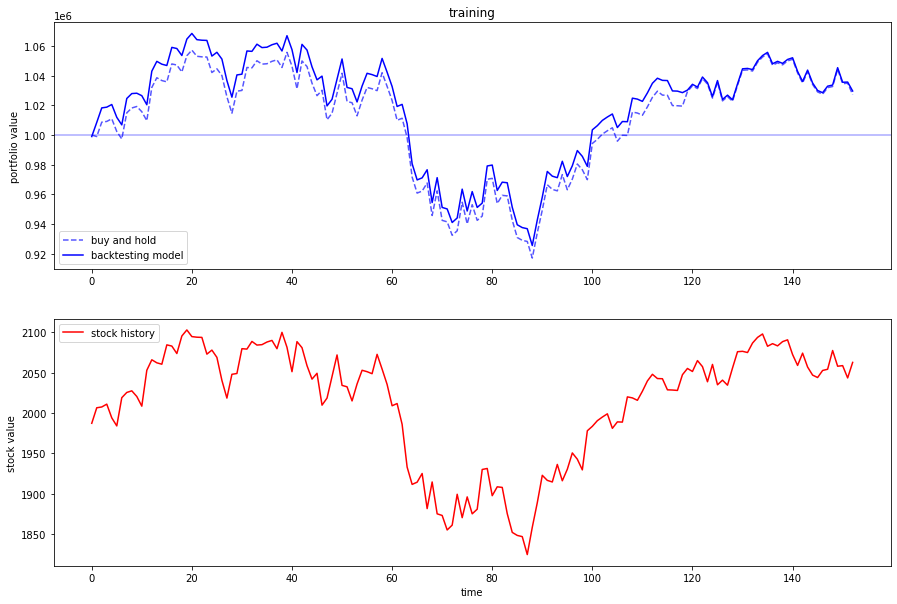

In [67]:
fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

ax1.plot(long, 'b--', alpha=0.667, label='buy and hold')
ax1.plot(history[i]['model'], 'b-', label='backtesting model')
ax1.axhline(env.balance_init, alpha=0.333, color='blue')
ax1.set_ylabel('portfolio value')
ax1.set_title('training')
ax1.legend()

ax2.plot(history[i]['stock'], 'r-', label='stock history')
ax2.set_ylabel('stock value')
ax2.set_xlabel('time')
ax2.legend()

plt.show();

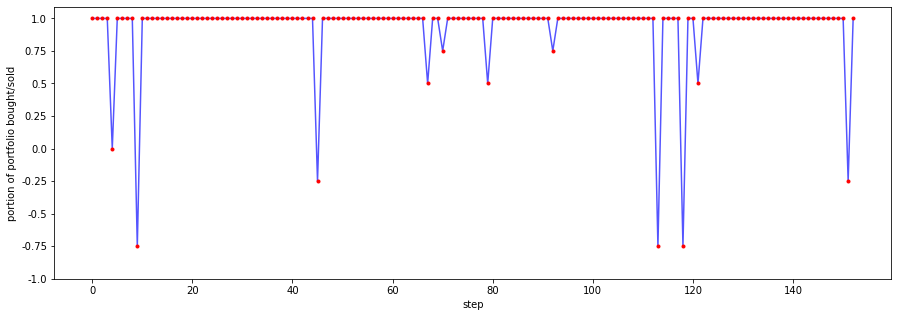

In [68]:
plt.figure(figsize=(15,5))
plt.plot(history[i]['actions'], 'b-', alpha=0.6667)
plt.plot(history[i]['actions'], 'r.')

plt.yticks(np.arange(dqn_solver.action_space), np.linspace(-1,1, dqn_solver.action_space))
plt.xlabel('step')
plt.ylabel('portion of portfolio bought/sold')
plt.show();

In [69]:
rewards = np.array([history[i]['rewards'] for i in np.arange(len(history))])

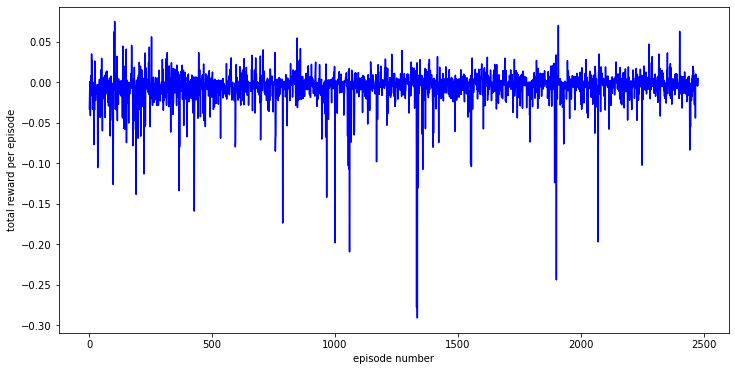

In [70]:
plt.figure(figsize=(12,6))
plt.plot(rewards, 'b-')
plt.xlabel('episode number')
plt.ylabel('total reward per episode')
plt.show();

In [71]:
print(corr(history[i]['stock'], history[i]['actions']))

0.014552264701859259


---

In [76]:
pickle_model(dqn_solver, path='model_info_sp500_1')

INFO:tensorflow:Assets written to: model_info_sp500_1\network.pb\assets
